# Entrenamiento de modelos de aprendizaje con el dataset Polyvore

**Autor:** Roberto Araya Day

**Fecha de inicio:** 16/11/2022

## 1. Preparación de datos

- El archivo *type_aware_polyvore_outfits.py* es el script de **Learning Type Aware Embeddings for Fashion Compatibility** para cargar el dataset de Polyvore y crear ejemplos. Se define un **TripletImageLoader** con una serie de transformaciones para las imágenes. Este archivo retorna *Triplets* de imágenes postivas y negativas. Modificamos este archivo en la forma de **DoubletImageLoader** para retornar pares de imágenes. Revisar el archivo. 
- El archivo *similarity_conditions_triplet_image_loader.py* es el script de **Learning similarity Conditions** para cargar triplets de datos de Polyvore. Revisar.

- Se dividen en los archivos:
    - ***fashion_compatibility_prediction.txt***: En ***fashion_compatibility_prediction_val.txt*** y ***fashion_compatibility_prediction_test.txt*** para las métricas de validación y testeo. Puesto que el archivo contiene **7076** columnas, se ponen **3538** ejemplos en cada archivo.
    - ***fill_in_blank_test.txt***.
---

Los modelos de recomendación están conformados por la siguiente estructura:
1. **DoubletImageLoader**: Carga las imágenes, con sus metadatos, y se crean los ejemplos de pares de prendas positivos. Es decir, prendas compatibles. Esta basado en los dataloader de ambas investigaciones señaladas anteriormente.
    - Un DataLoader es una estructura que combina un dataset y un sampler, y provee un iterador sobre el dataset.


2. **DoubletNet**: Genera los embeddings y calcula la pérdida y distancia entre los vectores obtenidos de los ejemplos positivos. No se necesita para este caso, puesto que el **Modelo General** lo hace por si solo. No necesita obtener el loss o accuracy de los pares de imágenes.


3. **Modelo General**: Variante del modelo BYOL que recibe dos imágenes de entrada.

In [1]:
# path de las imágenes de polyvore
import os
import itertools

# carpeta de las imágenes del dataset
# obtiene todas las imágenes en las carpetas (donde están guardados los modelos)
contador = 0
polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data', 'images')
for outfit_folder_name in os.listdir(polyvore_dataset):
    outfit_folder = os.path.join(polyvore_dataset, outfit_folder_name)
    outfit_clothes = [ os.path.join(outfit_folder, s) for s in os.listdir(outfit_folder)]
    pairs = list(itertools.combinations(outfit_clothes, 2))
    contador +=1
    if contador == 20: break


In [2]:
import sys

sys.path
sys.path.append('/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages')

In [3]:
# path to important folders
polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
polyvore_images = os.path.join(polyvore_dataset, 'images')
polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

polyvore_train = os.path.join(polyvore_info, 'train_no_dup')
polyvore_val = os.path.join(polyvore_info, 'valid_no_dup')
polyvore_test = os.path.join(polyvore_info, 'test_no_dup')

## 2. Instalación de los modelos de aprendizaje
### 2.1 Instalación del modelo BYOL

   Se instala la variante del modelo BYOL del trabajo de *Javier Morales Rodriguez* del repositorio *bimodal-byol-shoes*:
- https://github.com/javier-op/bimodal-byol-shoes.

In [4]:
%load_ext autoreload

In [5]:
%reload_ext autoreload

In [6]:
%autoreload 2

In [6]:
from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple
from bimodal_byol_shoes.models.BYOL2_model import BYOL2

transforms_1 = BatchTransform(SelectFromTuple(0))
transforms_2 = BatchTransform(SelectFromTuple(1))

# otros modelos importantes, codificador, se inicializa el modelo
encoder = models.resnet50(weights='DEFAULT')

#encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
empty_transform = T.Compose([])
epochs = 5
epoch_size = 300
byol_learner = BYOL2(
    encoder,
    image_size=224,
    hidden_layer='avgpool',
    augment_fn=empty_transform,
    cosine_ema_steps=epochs*epoch_size
)


NameError: name 'models' is not defined

In [ ]:
import gc 
images = None
images_embed_0 = None
images_embed_1 = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
    

## 3. Entrenamiento y resultados en las métricas de evaluación

Se entrenan los modelos definidos en la sección anterior, usando el *DataLoader* para cargar los datos. 

**IMPORTANTE**: *SelectFromTuple* no funciona bien. Por mientras se modifica BYOL2_model pero revisar bien la transformacion.

In [ ]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from polyvore_outfits_csa import TripletImageLoader
from tripletnet import Tripletnet
from tripletnet_original import Tripletnet as tripletnet_org
from tripletnet_color import Tripletnet as tripletnet_color
from ConditionalSimNet_adapt import ConditionalSimNet, ConditionalSimNet2, ConditionalSimNetNew, ConditionalSimNetRobert, ConditionalSimNetRobertSum
import sys
from sentence_transformers import SentenceTransformer
from PIL import Image
import itertools
import random

test_arg = False
use_fc_arg = False
learned_arg = True
prein_arg = True
epochs_args = 20
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
margin_arg = 0.3
lr_scheduler_arg = 0.9

# names of model
name_arg = 'BYOL_%s_conditions_%s_epochs' % (num_conditions, epochs_args)
resume_arg =  'runs/trained_models/%s/model_best.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=False,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def main():
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                 std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data, typespaces_csa,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)
    
    typespaces = typespaces_csa
    
    # definition of the model
    ## BYOL model
    transforms_1 = BatchTransform(SelectFromTuple(0))
    transforms_2 = BatchTransform(SelectFromTuple(1))

    encoder = models.resnet50(pretrained=False)
    empty_transform = T.Compose([])
    epoch_size = len(train_loader)
    learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )
    learner.augment1 = transforms_1
    learner.augment2 = transforms_2

    criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    if args.cuda:
        tnet.cuda()
    

    train_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'train', meta_data, typespaces_csa,
                           text_dim=text_feature_dim,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    
    
    val_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'valid', meta_data, typespaces_csa,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    best_acc = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            tnet.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True    
    if args.test:
        test_acc = test(test_loader, tnet)
        sys.exit()
        
    optimizer = optim.Adam(learner.parameters(), lr=args.lr, betas=(0.9, 0.999))
    
    n_parameters = sum([p.data.nelement() for p in tnet.parameters()])
    print('  + Number of params: {}'.format(n_parameters))

    for epoch in range(args.start_epoch, args.epochs + 1):
        # update learning rate
        adjust_learning_rate(optimizer, epoch)
        # train for one epoch
        train(train_loader, learner, criterion, optimizer, epoch)
        
        # evaluate on validation set
        acc = test(val_loader, learner)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': tnet.state_dict(),
            'best_prec1': best_acc,
        }, is_best)
        
        #lr_scheduler.step()
        

    checkpoint = torch.load('runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
    tnet.load_state_dict(checkpoint['state_dict'])
    test_acc = test(test_loader, tnet)

def train_original(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
        
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_vse, loss_sim_t, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        loss_sim = args.sim_t_loss * loss_sim_t + args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet + loss_reg
        if args.vse_loss > 0:
            loss += loss_vse_w
        if args.sim_t_loss > 0 or args.sim_i_loss > 0:
            loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        #mask_norms.update(loss_mask.item())
            
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))
            

def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
        
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        #loss_sim = args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        #loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        #loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet #+ loss_reg + loss_sim
        #if args.vse_loss > 0:
        #    loss += loss_vse_w
        #if args.sim_t_loss > 0 or args.sim_i_loss > 0:
        #    loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        #mask_norms.update(loss_mask.item())
        
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()
            

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/trained_models/%s/"%(args.name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
        
        
def test(test_loader, tnet):
    # switch to evaluation mode
    tnet.eval()
    embeddings = []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images in enumerate(test_loader):
        if args.cuda:
            images = images.cuda()
        images = Variable(images)
        embeddings.append(tnet.embeddingnet(images).data)
        
    embeddings = torch.cat(embeddings)
    metric = tnet.metric_branch
    auc = test_loader.dataset.test_compatibility(embeddings, metric)
    acc = test_loader.dataset.test_fitb(embeddings, metric)
    acc_var = test_loader.dataset.test_fitb_var(embeddings, metric)
    total = auc + acc + acc_var
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n FITB_var: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1), round(acc_var * 100, 1)))
    
    return total


class TrainData():
    def __init__(self, images, text, has_text, conditions = None):
        has_text = has_text.float()
        if args.cuda:
            images, text, has_text = images.cuda(), text.cuda(), has_text.cuda()
        images, text, has_text = Variable(images), Variable(text), Variable(has_text)
        
        if conditions is not None and not args.use_fc:
            if args.cuda:
                conditions = conditions.cuda()

            conditions = Variable(conditions)
        
        self.images = images
        self.text = text
        self.has_text = has_text
        self.conditions = conditions

    def __len__(self):
        return self.images.size(0)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * ((1 - 0.2) ** epoch)
    print('learning rate: ', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    main()

In [8]:
# si ocurre error DefaultCPUAllocator: can't allocate memory, reducir el num_workers y batch_size

from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

# important libraries for ML models
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2


#os.environ["CUDA_VISIBLE_DEVICES"]="0"

def main():
    torch.set_printoptions(linewidth=200)
    
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

    # info of training, validation and testing images and meta-data and load
    polyvore_train = os.path.join(polyvore_info, 'train_no_dup.json')
    polyvore_val = os.path.join(polyvore_info, 'valid_no_dup.json')
    polyvore_test = os.path.join(polyvore_info, 'test_no_dup.json')
    
    meta_data_train = json.load(open(polyvore_train, 'r'))
    meta_data_val = json.load(open(polyvore_val, 'r'))
    meta_data_test = json.load(open(polyvore_test, 'r'))
    
    # parámetros pre-definidos (revisar que se encuentren bien ajustados para la tarea )
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    batch_size = 400
    start_epoch = 0
    lr = 0.3
    
    # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'fashion_models', 'checkpoint_models')
    
    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")
    
    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
    
    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    val_arg = False
    test_arg = True
    #resume = os.path.join(models_folder, 'BYOL_03_04.pth.tar')
    resume = False
    
    
    ## DEFINITION of the BYOL model
    # transformation to the data
    # IMPORTANTE: Since the training data comes in the form of a list of postive examples: batch1, batch2, the
    # first arg is important, the second one gets the image into a device
    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])
    
    
    #rank = 0
    #world_size = 
    #setup(rank, world_size)
    
    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=None)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 40
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )
    
    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2
    
    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        #byol_learner = DDP(byol_learner, device_ids=[rank], output_device=rank, find_unused_parameters=True)
        byol_learner = nn.DataParallel(byol_learner)
    byol_learner.to(device)
        
    #move data to device
    #polyvore_images.to(device)
    #polyvore_info.to(device)
    
    # se define el DataLoader de los datos de testeo
    test_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                           ])),
        batch_size=batch_size, shuffle=False, **kwargs)

    
    
    
    # backbone for many computer vision tasks - "identity shortcut connection,” which allows the model to skip one or more layers
    
    #esta pre-entrenado
    
    # se crea el resnet pre-entrenado e inicializa BYOL con este modelo
    # buscar el modelo de restnet pre-entrenado
    # resnet = models.resnet50(weights='DEFAULT')
    # = BYOL(resnet, image_size = 256, hidden_layer = 'avgpool')
    # SimpleSiamese
    
    # se define el criterio de error: MarginRankingLoss y el modelo para medir la diferencia entre los embeddings finales
    #criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    #dnet = Doublenet(learner, criterion)
    

    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                           ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    val_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('valid', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                           ])),
        batch_size=batch_size, shuffle=False, **kwargs)
    
    best_val_loss = 1000000
    
    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            print('error justo despues')
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print(best_val_loss)
            print(start_epoch)
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))
    
    if val_arg:
        val_loss = valid_loss(byol_learner, val_loader, log_interval)
        print(val_loss)
        
    # cudnn.benchmark = True  
    if test_arg:
        test_acc = test(byol_learner, test_loader)
        return test_acc
    
    # se obtienen los parámetros del modelo de aprendizaje
    parameters = byol_learner.parameters()
    n_parameters = sum([p.data.nelement() for p in parameters])
    
    # se define el optimizador
    optimizer = torch.optim.Adam(byol_learner.parameters(), lr=lr, weight_decay=10**-6)
    
    print("Entra a la iteración")
    for epoch in range(start_epoch, epochs + 1):
        print("Número de épocas: ", epoch)
        
        # update learning rate
        adjust_learning_rate(lr, optimizer, epoch)
        
        # train for one epoch
        train(byol_learner, train_loader, optimizer, epoch, log_interval)
        # evaluate on validation set
        val_loss = valid_loss(byol_learner, val_loader, log_interval)

        # remember best acc and save checkpoint
        is_best = val_loss < best_val_loss
        best_val_loss = min(val_loss, best_val_loss)
        save_checkpoint(models_folder, {
            'epoch': epoch + 1,
            'state_dict': byol_learner.state_dict(),
            'best_prec1': best_val_loss,
        }, is_best, filename='random_model.pth.tar')

    checkpoint = torch.load(os.path.join(models_folder, 'random_model.pth.tar'))
    byol_learner.load_state_dict(checkpoint['state_dict'])
    
    test_acc = test(byol_learner, test_loader)
    print(test_acc)


def calculate_loss(criteria, img1embed, img2embed):
    return F.pairwise_distance(img1embed, img2embed)


def train(learner, train_loader, opt, epoch, log_interval):
    losses = AverageMeter()

    # switch to train mode
    for batch_idx, images_info in enumerate(train_loader):    
        
        # get info from images
        img1, img1category, img2, img2category = images_info
        images = [img1, img2]
        categories = [img1category, img2category]
        
        loss = learner(images)
        loss = loss.mean()
        # entrenamiento del modelo
        
        opt.zero_grad()
        loss.sum().backward()
        opt.step()
        learner.module.update_moving_average() # update moving average of target encoder
        
        num_items = images[0].shape[0]
                            
        # measure accuracy and record loss
        losses.update(loss.sum(), num_items)
        #emb_norms.update(embedding)
            
        # compute gradient and do optimizer step
        opt.zero_grad()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg))

            
def valid_loss(learner, test_loader, log_interval):
    losses = AverageMeter()

    # switch to train mod
    for batch_idx, images_info in enumerate(test_loader):
        
        # get info from images
        img1, img1category, img2, img2category = images_info
        images = [img1, img2]
        categories = [img1category, img2category]
        
        # entrenamiento del modelo
        with torch.no_grad():
            images_embed_0 = learner(images[0], return_embedding = 'online', return_projection = False)
            images_embed_1 = learner(images[1], return_embedding = 'online', return_projection = False)
            # definir función de perdida (OTRA MAS)
        
        loss = torch.mean(F.pairwise_distance(images_embed_0, images_embed_1))
        
        num_items = len(images_embed_0)
                            
        # measure accuracy and record loss
        losses.update(loss, num_items)
        #emb_norms.update(embedding)
    
        if batch_idx % log_interval == 0:
            print('Validation: [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'.format(
                batch_idx * num_items, len(test_loader.dataset),
                losses.val, losses.avg))
        
    print("Validation Loss Total: {}\t".format(losses.sum))
    print()
    return losses.sum
    
    

def test(learner, test_loader):
    global cuda
    global device
    # switch to evaluation mode
    embeddings_list = []
    # for test/val data we get images only from the data loader
    
    for batch_idx, images_info in enumerate(test_loader):
        
        # get info from images
        images, images_cat = images_info
        
        with torch.no_grad():
            projections, embeddings = learner(images, return_embedding = 'online')
        embeddings_list.append(embeddings)
    embeddings_list = torch.cat(embeddings_list)
    print('shape of embedding list: ', embeddings_list.shape)
    metric = None
    auc = test_loader.dataset.test_compatibility(embeddings_list, metric)
    acc = test_loader.dataset.test_fitb(embeddings_list, metric)
    total = auc + acc
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1)))
     
    return total

def save_checkpoint(models_folder, state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = models_folder
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = os.path.join(directory, filename)
    torch.save(state, filename)
    print('checkpoint is best: ', is_best)
    if is_best:
        shutil.copyfile(filename, os.path.join(directory, 'model_best.pth.tar'))

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * ((1 - 0.015) ** epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

if __name__ == '__main__':
    main()    

Let's use 2 GPUs!
shape of embedding list:  torch.Size([18604, 2048])
the index of the items:
0 1

the index of the items:
0 2

the index of the items:
0 3

the index of the items:
0 4

the index of the items:
1 2

the index of the items:
1 3

the index of the items:
1 4

the index of the items:
2 3

the index of the items:
2 4

the index of the items:
3 4

the index of the items:
5 6

the index of the items:
5 7

the index of the items:
5 8

the index of the items:
5 9

the index of the items:
5 10

the index of the items:
5 11

the index of the items:
5 12

the index of the items:
6 7

the index of the items:
6 8

the index of the items:
6 9

the index of the items:
6 10

the index of the items:
6 11

the index of the items:
6 12

the index of the items:
7 8

the index of the items:
7 9

the index of the items:
7 10

the index of the items:
7 11

the index of the items:
7 12

the index of the items:
8 9

the index of the items:
8 10

the index of the items:
8 11

the index of the ite

the index of the items:
388 390

the index of the items:
388 391

the index of the items:
388 392

the index of the items:
389 390

the index of the items:
389 391

the index of the items:
389 392

the index of the items:
390 391

the index of the items:
390 392

the index of the items:
391 392

the index of the items:
393 394

the index of the items:
393 395

the index of the items:
393 396

the index of the items:
393 397

the index of the items:
394 395

the index of the items:
394 396

the index of the items:
394 397

the index of the items:
395 396

the index of the items:
395 397

the index of the items:
396 397

the index of the items:
398 399

the index of the items:
398 400

the index of the items:
398 401

the index of the items:
398 402

the index of the items:
398 403

the index of the items:
399 400

the index of the items:
399 401

the index of the items:
399 402

the index of the items:
399 403

the index of the items:
400 401

the index of the items:
400 402

the index 

the index of the items:
1422 1425

the index of the items:
1422 1426

the index of the items:
1423 1424

the index of the items:
1423 1425

the index of the items:
1423 1426

the index of the items:
1424 1425

the index of the items:
1424 1426

the index of the items:
1425 1426

the index of the items:
1427 1428

the index of the items:
1427 1429

the index of the items:
1427 1430

the index of the items:
1428 1429

the index of the items:
1428 1430

the index of the items:
1429 1430

the index of the items:
1431 1432

the index of the items:
1431 1433

the index of the items:
1431 1434

the index of the items:
1431 1435

the index of the items:
1432 1433

the index of the items:
1432 1434

the index of the items:
1432 1435

the index of the items:
1433 1434

the index of the items:
1433 1435

the index of the items:
1434 1435

the index of the items:
1436 1437

the index of the items:
1436 1438

the index of the items:
1436 1439

the index of the items:
1436 1440

the index of the ite

the index of the items:
2298 2299

the index of the items:
2298 2300

the index of the items:
2298 2301

the index of the items:
2298 2302

the index of the items:
2299 2300

the index of the items:
2299 2301

the index of the items:
2299 2302

the index of the items:
2300 2301

the index of the items:
2300 2302

the index of the items:
2301 2302

the index of the items:
2303 2304

the index of the items:
2303 2305

the index of the items:
2303 2306

the index of the items:
2303 2307

the index of the items:
2303 2308

the index of the items:
2304 2305

the index of the items:
2304 2306

the index of the items:
2304 2307

the index of the items:
2304 2308

the index of the items:
2305 2306

the index of the items:
2305 2307

the index of the items:
2305 2308

the index of the items:
2306 2307

the index of the items:
2306 2308

the index of the items:
2307 2308

the index of the items:
2309 2310

the index of the items:
2309 2311

the index of the items:
2309 2312

the index of the ite

the index of the items:
3065 3069

the index of the items:
3065 3070

the index of the items:
3066 3067

the index of the items:
3066 3068

the index of the items:
3066 3069

the index of the items:
3066 3070

the index of the items:
3067 3068

the index of the items:
3067 3069

the index of the items:
3067 3070

the index of the items:
3068 3069

the index of the items:
3068 3070

the index of the items:
3069 3070

the index of the items:
3071 3072

the index of the items:
3071 3073

the index of the items:
3071 3074

the index of the items:
3071 3075

the index of the items:
3071 3076

the index of the items:
3071 3077

the index of the items:
3072 3073

the index of the items:
3072 3074

the index of the items:
3072 3075

the index of the items:
3072 3076

the index of the items:
3072 3077

the index of the items:
3073 3074

the index of the items:
3073 3075

the index of the items:
3073 3076

the index of the items:
3073 3077

the index of the items:
3074 3075

the index of the ite

the index of the items:
3773 3775

the index of the items:
3773 3776

the index of the items:
3774 3775

the index of the items:
3774 3776

the index of the items:
3775 3776

the index of the items:
3777 3778

the index of the items:
3777 3779

the index of the items:
3777 3780

the index of the items:
3777 3781

the index of the items:
3777 3782

the index of the items:
3778 3779

the index of the items:
3778 3780

the index of the items:
3778 3781

the index of the items:
3778 3782

the index of the items:
3779 3780

the index of the items:
3779 3781

the index of the items:
3779 3782

the index of the items:
3780 3781

the index of the items:
3780 3782

the index of the items:
3781 3782

the index of the items:
3783 3784

the index of the items:
3783 3785

the index of the items:
3783 3786

the index of the items:
3783 3787

the index of the items:
3783 3788

the index of the items:
3783 3789

the index of the items:
3783 3790

the index of the items:
3784 3785

the index of the ite

the index of the items:
4384 4387

the index of the items:
4385 4386

the index of the items:
4385 4387

the index of the items:
4386 4387

the index of the items:
4388 4389

the index of the items:
4388 4390

the index of the items:
4388 4391

the index of the items:
4388 4392

the index of the items:
4389 4390

the index of the items:
4389 4391

the index of the items:
4389 4392

the index of the items:
4390 4391

the index of the items:
4390 4392

the index of the items:
4391 4392

the index of the items:
4393 4394

the index of the items:
4393 4395

the index of the items:
4393 4396

the index of the items:
4393 4397

the index of the items:
4393 4398

the index of the items:
4393 4399

the index of the items:
4394 4395

the index of the items:
4394 4396

the index of the items:
4394 4397

the index of the items:
4394 4398

the index of the items:
4394 4399

the index of the items:
4395 4396

the index of the items:
4395 4397

the index of the items:
4395 4398

the index of the ite

the index of the items:
4973 4975

the index of the items:
4973 4976

the index of the items:
4974 4975

the index of the items:
4974 4976

the index of the items:
4975 4976

the index of the items:
4977 4978

the index of the items:
4977 4979

the index of the items:
4977 4980

the index of the items:
4977 4981

the index of the items:
4977 4982

the index of the items:
4977 4983

the index of the items:
4977 4984

the index of the items:
4978 4979

the index of the items:
4978 4980

the index of the items:
4978 4981

the index of the items:
4978 4982

the index of the items:
4978 4983

the index of the items:
4978 4984

the index of the items:
4979 4980

the index of the items:
4979 4981

the index of the items:
4979 4982

the index of the items:
4979 4983

the index of the items:
4979 4984

the index of the items:
4980 4981

the index of the items:
4980 4982

the index of the items:
4980 4983

the index of the items:
4980 4984

the index of the items:
4981 4982

the index of the ite

the index of the items:
5553 5555

the index of the items:
5553 5556

the index of the items:
5554 5555

the index of the items:
5554 5556

the index of the items:
5555 5556

the index of the items:
5557 5558

the index of the items:
5557 5559

the index of the items:
5557 5560

the index of the items:
5557 5561

the index of the items:
5558 5559

the index of the items:
5558 5560

the index of the items:
5558 5561

the index of the items:
5559 5560

the index of the items:
5559 5561

the index of the items:
5560 5561

the index of the items:
5562 5563

the index of the items:
5562 5564

the index of the items:
5562 5565

the index of the items:
5563 5564

the index of the items:
5563 5565

the index of the items:
5564 5565

the index of the items:
5566 5567

the index of the items:
5566 5568

the index of the items:
5566 5569

the index of the items:
5566 5570

the index of the items:
5567 5568

the index of the items:
5567 5569

the index of the items:
5567 5570

the index of the ite

the index of the items:
6100 6104

the index of the items:
6100 6105

the index of the items:
6100 6106

the index of the items:
6101 6102

the index of the items:
6101 6103

the index of the items:
6101 6104

the index of the items:
6101 6105

the index of the items:
6101 6106

the index of the items:
6102 6103

the index of the items:
6102 6104

the index of the items:
6102 6105

the index of the items:
6102 6106

the index of the items:
6103 6104

the index of the items:
6103 6105

the index of the items:
6103 6106

the index of the items:
6104 6105

the index of the items:
6104 6106

the index of the items:
6105 6106

the index of the items:
6107 6108

the index of the items:
6107 6109

the index of the items:
6107 6110

the index of the items:
6107 6111

the index of the items:
6107 6112

the index of the items:
6107 6113

the index of the items:
6108 6109

the index of the items:
6108 6110

the index of the items:
6108 6111

the index of the items:
6108 6112

the index of the ite

the index of the items:
6630 6632

the index of the items:
6630 6633

the index of the items:
6630 6634

the index of the items:
6630 6635

the index of the items:
6631 6632

the index of the items:
6631 6633

the index of the items:
6631 6634

the index of the items:
6631 6635

the index of the items:
6632 6633

the index of the items:
6632 6634

the index of the items:
6632 6635

the index of the items:
6633 6634

the index of the items:
6633 6635

the index of the items:
6634 6635

the index of the items:
6636 6637

the index of the items:
6636 6638

the index of the items:
6636 6639

the index of the items:
6636 6640

the index of the items:
6636 6641

the index of the items:
6636 6642

the index of the items:
6636 6643

the index of the items:
6637 6638

the index of the items:
6637 6639

the index of the items:
6637 6640

the index of the items:
6637 6641

the index of the items:
6637 6642

the index of the items:
6637 6643

the index of the items:
6638 6639

the index of the ite

the index of the items:
7115 7119

the index of the items:
7116 7117

the index of the items:
7116 7118

the index of the items:
7116 7119

the index of the items:
7117 7118

the index of the items:
7117 7119

the index of the items:
7118 7119

the index of the items:
7120 7121

the index of the items:
7120 7122

the index of the items:
7120 7123

the index of the items:
7120 7124

the index of the items:
7120 7125

the index of the items:
7121 7122

the index of the items:
7121 7123

the index of the items:
7121 7124

the index of the items:
7121 7125

the index of the items:
7122 7123

the index of the items:
7122 7124

the index of the items:
7122 7125

the index of the items:
7123 7124

the index of the items:
7123 7125

the index of the items:
7124 7125

the index of the items:
7126 7127

the index of the items:
7126 7128

the index of the items:
7126 7129

the index of the items:
7126 7130

the index of the items:
7126 7131

the index of the items:
7126 7132

the index of the ite

the index of the items:
7582 7583

the index of the items:
7582 7584

the index of the items:
7582 7585

the index of the items:
7583 7584

the index of the items:
7583 7585

the index of the items:
7584 7585

the index of the items:
7586 7587

the index of the items:
7586 7588

the index of the items:
7586 7589

the index of the items:
7586 7590

the index of the items:
7586 7591

the index of the items:
7586 7592

the index of the items:
7586 7593

the index of the items:
7587 7588

the index of the items:
7587 7589

the index of the items:
7587 7590

the index of the items:
7587 7591

the index of the items:
7587 7592

the index of the items:
7587 7593

the index of the items:
7588 7589

the index of the items:
7588 7590

the index of the items:
7588 7591

the index of the items:
7588 7592

the index of the items:
7588 7593

the index of the items:
7589 7590

the index of the items:
7589 7591

the index of the items:
7589 7592

the index of the items:
7589 7593

the index of the ite

the index of the items:
8040 8043

the index of the items:
8041 8042

the index of the items:
8041 8043

the index of the items:
8042 8043

the index of the items:
8044 8045

the index of the items:
8044 8046

the index of the items:
8044 8047

the index of the items:
8044 8048

the index of the items:
8044 8049

the index of the items:
8045 8046

the index of the items:
8045 8047

the index of the items:
8045 8048

the index of the items:
8045 8049

the index of the items:
8046 8047

the index of the items:
8046 8048

the index of the items:
8046 8049

the index of the items:
8047 8048

the index of the items:
8047 8049

the index of the items:
8048 8049

the index of the items:
8050 8051

the index of the items:
8050 8052

the index of the items:
8050 8053

the index of the items:
8050 8054

the index of the items:
8050 8055

the index of the items:
8050 8056

the index of the items:
8050 8057

the index of the items:
8051 8052

the index of the items:
8051 8053

the index of the ite

the index of the items:
8469 8474

the index of the items:
8470 8471

the index of the items:
8470 8472

the index of the items:
8470 8473

the index of the items:
8470 8474

the index of the items:
8471 8472

the index of the items:
8471 8473

the index of the items:
8471 8474

the index of the items:
8472 8473

the index of the items:
8472 8474

the index of the items:
8473 8474

the index of the items:
8475 8476

the index of the items:
8475 8477

the index of the items:
8475 8478

the index of the items:
8476 8477

the index of the items:
8476 8478

the index of the items:
8477 8478

the index of the items:
8479 8480

the index of the items:
8479 8481

the index of the items:
8479 8482

the index of the items:
8479 8483

the index of the items:
8479 8484

the index of the items:
8480 8481

the index of the items:
8480 8482

the index of the items:
8480 8483

the index of the items:
8480 8484

the index of the items:
8481 8482

the index of the items:
8481 8483

the index of the ite

the index of the items:
8897 8898

the index of the items:
8897 8899

the index of the items:
8897 8900

the index of the items:
8897 8901

the index of the items:
8898 8899

the index of the items:
8898 8900

the index of the items:
8898 8901

the index of the items:
8899 8900

the index of the items:
8899 8901

the index of the items:
8900 8901

the index of the items:
8902 8903

the index of the items:
8902 8904

the index of the items:
8902 8905

the index of the items:
8902 8906

the index of the items:
8902 8907

the index of the items:
8902 8908

the index of the items:
8903 8904

the index of the items:
8903 8905

the index of the items:
8903 8906

the index of the items:
8903 8907

the index of the items:
8903 8908

the index of the items:
8904 8905

the index of the items:
8904 8906

the index of the items:
8904 8907

the index of the items:
8904 8908

the index of the items:
8905 8906

the index of the items:
8905 8907

the index of the items:
8905 8908

the index of the ite

the index of the items:
9303 9307

the index of the items:
9303 9308

the index of the items:
9304 9305

the index of the items:
9304 9306

the index of the items:
9304 9307

the index of the items:
9304 9308

the index of the items:
9305 9306

the index of the items:
9305 9307

the index of the items:
9305 9308

the index of the items:
9306 9307

the index of the items:
9306 9308

the index of the items:
9307 9308

the index of the items:
9309 9310

the index of the items:
9309 9311

the index of the items:
9309 9312

the index of the items:
9310 9311

the index of the items:
9310 9312

the index of the items:
9311 9312

the index of the items:
9313 9314

the index of the items:
9313 9315

the index of the items:
9313 9316

the index of the items:
9313 9317

the index of the items:
9314 9315

the index of the items:
9314 9316

the index of the items:
9314 9317

the index of the items:
9315 9316

the index of the items:
9315 9317

the index of the items:
9316 9317

the index of the ite

the index of the items:
9712 9715

the index of the items:
9712 9716

the index of the items:
9713 9714

the index of the items:
9713 9715

the index of the items:
9713 9716

the index of the items:
9714 9715

the index of the items:
9714 9716

the index of the items:
9715 9716

the index of the items:
9717 9718

the index of the items:
9717 9719

the index of the items:
9717 9720

the index of the items:
9717 9721

the index of the items:
9717 9722

the index of the items:
9718 9719

the index of the items:
9718 9720

the index of the items:
9718 9721

the index of the items:
9718 9722

the index of the items:
9719 9720

the index of the items:
9719 9721

the index of the items:
9719 9722

the index of the items:
9720 9721

the index of the items:
9720 9722

the index of the items:
9721 9722

the index of the items:
9723 9724

the index of the items:
9723 9725

the index of the items:
9723 9726

the index of the items:
9723 9727

the index of the items:
9723 9728

the index of the ite

the index of the items:
10109 10111

the index of the items:
10110 10111

the index of the items:
10112 10113

the index of the items:
10112 10114

the index of the items:
10112 10115

the index of the items:
10112 10116

the index of the items:
10112 10117

the index of the items:
10112 10118

the index of the items:
10112 10119

the index of the items:
10113 10114

the index of the items:
10113 10115

the index of the items:
10113 10116

the index of the items:
10113 10117

the index of the items:
10113 10118

the index of the items:
10113 10119

the index of the items:
10114 10115

the index of the items:
10114 10116

the index of the items:
10114 10117

the index of the items:
10114 10118

the index of the items:
10114 10119

the index of the items:
10115 10116

the index of the items:
10115 10117

the index of the items:
10115 10118

the index of the items:
10115 10119

the index of the items:
10116 10117

the index of the items:
10116 10118

the index of the items:
10116 10119

t

the index of the items:
10474 10481

the index of the items:
10475 10476

the index of the items:
10475 10477

the index of the items:
10475 10478

the index of the items:
10475 10479

the index of the items:
10475 10480

the index of the items:
10475 10481

the index of the items:
10476 10477

the index of the items:
10476 10478

the index of the items:
10476 10479

the index of the items:
10476 10480

the index of the items:
10476 10481

the index of the items:
10477 10478

the index of the items:
10477 10479

the index of the items:
10477 10480

the index of the items:
10477 10481

the index of the items:
10478 10479

the index of the items:
10478 10480

the index of the items:
10478 10481

the index of the items:
10479 10480

the index of the items:
10479 10481

the index of the items:
10480 10481

the index of the items:
10482 10483

the index of the items:
10482 10484

the index of the items:
10482 10485

the index of the items:
10482 10486

the index of the items:
10482 10487

t

the index of the items:
10841 10848

the index of the items:
10842 10843

the index of the items:
10842 10844

the index of the items:
10842 10845

the index of the items:
10842 10846

the index of the items:
10842 10847

the index of the items:
10842 10848

the index of the items:
10843 10844

the index of the items:
10843 10845

the index of the items:
10843 10846

the index of the items:
10843 10847

the index of the items:
10843 10848

the index of the items:
10844 10845

the index of the items:
10844 10846

the index of the items:
10844 10847

the index of the items:
10844 10848

the index of the items:
10845 10846

the index of the items:
10845 10847

the index of the items:
10845 10848

the index of the items:
10846 10847

the index of the items:
10846 10848

the index of the items:
10847 10848

the index of the items:
10849 10850

the index of the items:
10849 10851

the index of the items:
10849 10852

the index of the items:
10849 10853

the index of the items:
10849 10854

t

the index of the items:
11187 11188

the index of the items:
11187 11189

the index of the items:
11187 11190

the index of the items:
11187 11191

the index of the items:
11187 11192

the index of the items:
11188 11189

the index of the items:
11188 11190

the index of the items:
11188 11191

the index of the items:
11188 11192

the index of the items:
11189 11190

the index of the items:
11189 11191

the index of the items:
11189 11192

the index of the items:
11190 11191

the index of the items:
11190 11192

the index of the items:
11191 11192

the index of the items:
11193 11194

the index of the items:
11193 11195

the index of the items:
11193 11196

the index of the items:
11193 11197

the index of the items:
11193 11198

the index of the items:
11194 11195

the index of the items:
11194 11196

the index of the items:
11194 11197

the index of the items:
11194 11198

the index of the items:
11195 11196

the index of the items:
11195 11197

the index of the items:
11195 11198

t

the index of the items:
11534 11535

the index of the items:
11534 11536

the index of the items:
11534 11537

the index of the items:
11534 11538

the index of the items:
11534 11539

the index of the items:
11534 11540

the index of the items:
11535 11536

the index of the items:
11535 11537

the index of the items:
11535 11538

the index of the items:
11535 11539

the index of the items:
11535 11540

the index of the items:
11536 11537

the index of the items:
11536 11538

the index of the items:
11536 11539

the index of the items:
11536 11540

the index of the items:
11537 11538

the index of the items:
11537 11539

the index of the items:
11537 11540

the index of the items:
11538 11539

the index of the items:
11538 11540

the index of the items:
11539 11540

the index of the items:
11541 11542

the index of the items:
11541 11543

the index of the items:
11541 11544

the index of the items:
11541 11545

the index of the items:
11542 11543

the index of the items:
11542 11544

t

the index of the items:
11880 11885

the index of the items:
11880 11886

the index of the items:
11880 11887

the index of the items:
11881 11882

the index of the items:
11881 11883

the index of the items:
11881 11884

the index of the items:
11881 11885

the index of the items:
11881 11886

the index of the items:
11881 11887

the index of the items:
11882 11883

the index of the items:
11882 11884

the index of the items:
11882 11885

the index of the items:
11882 11886

the index of the items:
11882 11887

the index of the items:
11883 11884

the index of the items:
11883 11885

the index of the items:
11883 11886

the index of the items:
11883 11887

the index of the items:
11884 11885

the index of the items:
11884 11886

the index of the items:
11884 11887

the index of the items:
11885 11886

the index of the items:
11885 11887

the index of the items:
11886 11887

the index of the items:
11888 11889

the index of the items:
11888 11890

the index of the items:
11888 11891

t

the index of the items:
12210 12211

the index of the items:
12210 12212

the index of the items:
12210 12213

the index of the items:
12210 12214

the index of the items:
12210 12215

the index of the items:
12210 12216

the index of the items:
12211 12212

the index of the items:
12211 12213

the index of the items:
12211 12214

the index of the items:
12211 12215

the index of the items:
12211 12216

the index of the items:
12212 12213

the index of the items:
12212 12214

the index of the items:
12212 12215

the index of the items:
12212 12216

the index of the items:
12213 12214

the index of the items:
12213 12215

the index of the items:
12213 12216

the index of the items:
12214 12215

the index of the items:
12214 12216

the index of the items:
12215 12216

the index of the items:
12217 12218

the index of the items:
12217 12219

the index of the items:
12217 12220

the index of the items:
12217 12221

the index of the items:
12217 12222

the index of the items:
12217 12223

t

the index of the items:
12540 12541

the index of the items:
12540 12542

the index of the items:
12540 12543

the index of the items:
12541 12542

the index of the items:
12541 12543

the index of the items:
12542 12543

the index of the items:
12544 12545

the index of the items:
12544 12546

the index of the items:
12544 12547

the index of the items:
12544 12548

the index of the items:
12544 12549

the index of the items:
12544 12550

the index of the items:
12544 12551

the index of the items:
12545 12546

the index of the items:
12545 12547

the index of the items:
12545 12548

the index of the items:
12545 12549

the index of the items:
12545 12550

the index of the items:
12545 12551

the index of the items:
12546 12547

the index of the items:
12546 12548

the index of the items:
12546 12549

the index of the items:
12546 12550

the index of the items:
12546 12551

the index of the items:
12547 12548

the index of the items:
12547 12549

the index of the items:
12547 12550

t

the index of the items:
12856 12858

the index of the items:
12857 12858

the index of the items:
12859 12860

the index of the items:
12859 12861

the index of the items:
12859 12862

the index of the items:
12859 12863

the index of the items:
12860 12861

the index of the items:
12860 12862

the index of the items:
12860 12863

the index of the items:
12861 12862

the index of the items:
12861 12863

the index of the items:
12862 12863

the index of the items:
12864 12865

the index of the items:
12864 12866

the index of the items:
12864 12867

the index of the items:
12865 12866

the index of the items:
12865 12867

the index of the items:
12866 12867

the index of the items:
12868 12869

the index of the items:
12868 12870

the index of the items:
12868 12871

the index of the items:
12868 12872

the index of the items:
12868 12873

the index of the items:
12868 12874

the index of the items:
12868 12875

the index of the items:
12869 12870

the index of the items:
12869 12871

t

the index of the items:
13189 13193

the index of the items:
13189 13194

the index of the items:
13190 13191

the index of the items:
13190 13192

the index of the items:
13190 13193

the index of the items:
13190 13194

the index of the items:
13191 13192

the index of the items:
13191 13193

the index of the items:
13191 13194

the index of the items:
13192 13193

the index of the items:
13192 13194

the index of the items:
13193 13194

the index of the items:
13195 13196

the index of the items:
13195 13197

the index of the items:
13195 13198

the index of the items:
13195 13199

the index of the items:
13195 13200

the index of the items:
13196 13197

the index of the items:
13196 13198

the index of the items:
13196 13199

the index of the items:
13196 13200

the index of the items:
13197 13198

the index of the items:
13197 13199

the index of the items:
13197 13200

the index of the items:
13198 13199

the index of the items:
13198 13200

the index of the items:
13199 13200

t

the index of the items:
13494 13496

the index of the items:
13494 13497

the index of the items:
13494 13498

the index of the items:
13494 13499

the index of the items:
13494 13500

the index of the items:
13494 13501

the index of the items:
13495 13496

the index of the items:
13495 13497

the index of the items:
13495 13498

the index of the items:
13495 13499

the index of the items:
13495 13500

the index of the items:
13495 13501

the index of the items:
13496 13497

the index of the items:
13496 13498

the index of the items:
13496 13499

the index of the items:
13496 13500

the index of the items:
13496 13501

the index of the items:
13497 13498

the index of the items:
13497 13499

the index of the items:
13497 13500

the index of the items:
13497 13501

the index of the items:
13498 13499

the index of the items:
13498 13500

the index of the items:
13498 13501

the index of the items:
13499 13500

the index of the items:
13499 13501

the index of the items:
13500 13501

t

the index of the items:
13797 13798

the index of the items:
13799 13800

the index of the items:
13799 13801

the index of the items:
13799 13802

the index of the items:
13799 13803

the index of the items:
13799 13804

the index of the items:
13800 13801

the index of the items:
13800 13802

the index of the items:
13800 13803

the index of the items:
13800 13804

the index of the items:
13801 13802

the index of the items:
13801 13803

the index of the items:
13801 13804

the index of the items:
13802 13803

the index of the items:
13802 13804

the index of the items:
13803 13804

the index of the items:
13805 13806

the index of the items:
13805 13807

the index of the items:
13805 13808

the index of the items:
13805 13809

the index of the items:
13806 13807

the index of the items:
13806 13808

the index of the items:
13806 13809

the index of the items:
13807 13808

the index of the items:
13807 13809

the index of the items:
13808 13809

the index of the items:
13810 13811

t

the index of the items:
14110 14112

the index of the items:
14110 14113

the index of the items:
14111 14112

the index of the items:
14111 14113

the index of the items:
14112 14113

the index of the items:
14114 14115

the index of the items:
14114 14116

the index of the items:
14114 14117

the index of the items:
14114 14118

the index of the items:
14114 14119

the index of the items:
14115 14116

the index of the items:
14115 14117

the index of the items:
14115 14118

the index of the items:
14115 14119

the index of the items:
14116 14117

the index of the items:
14116 14118

the index of the items:
14116 14119

the index of the items:
14117 14118

the index of the items:
14117 14119

the index of the items:
14118 14119

the index of the items:
14120 14121

the index of the items:
14120 14122

the index of the items:
14120 14123

the index of the items:
14120 14124

the index of the items:
14121 14122

the index of the items:
14121 14123

the index of the items:
14121 14124

t

the index of the items:
14414 14417

the index of the items:
14414 14418

the index of the items:
14414 14419

the index of the items:
14415 14416

the index of the items:
14415 14417

the index of the items:
14415 14418

the index of the items:
14415 14419

the index of the items:
14416 14417

the index of the items:
14416 14418

the index of the items:
14416 14419

the index of the items:
14417 14418

the index of the items:
14417 14419

the index of the items:
14418 14419

the index of the items:
14420 14421

the index of the items:
14420 14422

the index of the items:
14420 14423

the index of the items:
14420 14424

the index of the items:
14420 14425

the index of the items:
14420 14426

the index of the items:
14420 14427

the index of the items:
14421 14422

the index of the items:
14421 14423

the index of the items:
14421 14424

the index of the items:
14421 14425

the index of the items:
14421 14426

the index of the items:
14421 14427

the index of the items:
14422 14423

t

the index of the items:
14704 14707

the index of the items:
14705 14706

the index of the items:
14705 14707

the index of the items:
14706 14707

the index of the items:
14708 14709

the index of the items:
14708 14710

the index of the items:
14708 14711

the index of the items:
14708 14712

the index of the items:
14708 14713

the index of the items:
14708 14714

the index of the items:
14708 14715

the index of the items:
14709 14710

the index of the items:
14709 14711

the index of the items:
14709 14712

the index of the items:
14709 14713

the index of the items:
14709 14714

the index of the items:
14709 14715

the index of the items:
14710 14711

the index of the items:
14710 14712

the index of the items:
14710 14713

the index of the items:
14710 14714

the index of the items:
14710 14715

the index of the items:
14711 14712

the index of the items:
14711 14713

the index of the items:
14711 14714

the index of the items:
14711 14715

the index of the items:
14712 14713

t

the index of the items:
14979 14981

the index of the items:
14979 14982

the index of the items:
14979 14983

the index of the items:
14979 14984

the index of the items:
14979 14985

the index of the items:
14980 14981

the index of the items:
14980 14982

the index of the items:
14980 14983

the index of the items:
14980 14984

the index of the items:
14980 14985

the index of the items:
14981 14982

the index of the items:
14981 14983

the index of the items:
14981 14984

the index of the items:
14981 14985

the index of the items:
14982 14983

the index of the items:
14982 14984

the index of the items:
14982 14985

the index of the items:
14983 14984

the index of the items:
14983 14985

the index of the items:
14984 14985

the index of the items:
14986 14987

the index of the items:
14986 14988

the index of the items:
14986 14989

the index of the items:
14986 14990

the index of the items:
14986 14991

the index of the items:
14986 14992

the index of the items:
14986 14993

t

the index of the items:
15255 15256

the index of the items:
15255 15257

the index of the items:
15255 15258

the index of the items:
15255 15259

the index of the items:
15255 15260

the index of the items:
15256 15257

the index of the items:
15256 15258

the index of the items:
15256 15259

the index of the items:
15256 15260

the index of the items:
15257 15258

the index of the items:
15257 15259

the index of the items:
15257 15260

the index of the items:
15258 15259

the index of the items:
15258 15260

the index of the items:
15259 15260

the index of the items:
15261 15262

the index of the items:
15261 15263

the index of the items:
15261 15264

the index of the items:
15261 15265

the index of the items:
15261 15266

the index of the items:
15261 15267

the index of the items:
15261 15268

the index of the items:
15262 15263

the index of the items:
15262 15264

the index of the items:
15262 15265

the index of the items:
15262 15266

the index of the items:
15262 15267

t

the index of the items:
15539 15541

the index of the items:
15539 15542

the index of the items:
15539 15543

the index of the items:
15539 15544

the index of the items:
15539 15545

the index of the items:
15539 15546

the index of the items:
15540 15541

the index of the items:
15540 15542

the index of the items:
15540 15543

the index of the items:
15540 15544

the index of the items:
15540 15545

the index of the items:
15540 15546

the index of the items:
15541 15542

the index of the items:
15541 15543

the index of the items:
15541 15544

the index of the items:
15541 15545

the index of the items:
15541 15546

the index of the items:
15542 15543

the index of the items:
15542 15544

the index of the items:
15542 15545

the index of the items:
15542 15546

the index of the items:
15543 15544

the index of the items:
15543 15545

the index of the items:
15543 15546

the index of the items:
15544 15545

the index of the items:
15544 15546

the index of the items:
15545 15546

t

the index of the items:
15810 15812

the index of the items:
15810 15813

the index of the items:
15811 15812

the index of the items:
15811 15813

the index of the items:
15812 15813

the index of the items:
15814 15815

the index of the items:
15814 15816

the index of the items:
15814 15817

the index of the items:
15815 15816

the index of the items:
15815 15817

the index of the items:
15816 15817

the index of the items:
15818 15819

the index of the items:
15818 15820

the index of the items:
15818 15821

the index of the items:
15818 15822

the index of the items:
15818 15823

the index of the items:
15818 15824

the index of the items:
15818 15825

the index of the items:
15819 15820

the index of the items:
15819 15821

the index of the items:
15819 15822

the index of the items:
15819 15823

the index of the items:
15819 15824

the index of the items:
15819 15825

the index of the items:
15820 15821

the index of the items:
15820 15822

the index of the items:
15820 15823

t

the index of the items:
16085 16087

the index of the items:
16086 16087

the index of the items:
16088 16089

the index of the items:
16088 16090

the index of the items:
16088 16091

the index of the items:
16088 16092

the index of the items:
16088 16093

the index of the items:
16088 16094

the index of the items:
16089 16090

the index of the items:
16089 16091

the index of the items:
16089 16092

the index of the items:
16089 16093

the index of the items:
16089 16094

the index of the items:
16090 16091

the index of the items:
16090 16092

the index of the items:
16090 16093

the index of the items:
16090 16094

the index of the items:
16091 16092

the index of the items:
16091 16093

the index of the items:
16091 16094

the index of the items:
16092 16093

the index of the items:
16092 16094

the index of the items:
16093 16094

the index of the items:
16095 16096

the index of the items:
16095 16097

the index of the items:
16095 16098

the index of the items:
16095 16099

t

the index of the items:
16363 16366

the index of the items:
16363 16367

the index of the items:
16363 16368

the index of the items:
16364 16365

the index of the items:
16364 16366

the index of the items:
16364 16367

the index of the items:
16364 16368

the index of the items:
16365 16366

the index of the items:
16365 16367

the index of the items:
16365 16368

the index of the items:
16366 16367

the index of the items:
16366 16368

the index of the items:
16367 16368

the index of the items:
16369 16370

the index of the items:
16369 16371

the index of the items:
16369 16372

the index of the items:
16369 16373

the index of the items:
16369 16374

the index of the items:
16369 16375

the index of the items:
16370 16371

the index of the items:
16370 16372

the index of the items:
16370 16373

the index of the items:
16370 16374

the index of the items:
16370 16375

the index of the items:
16371 16372

the index of the items:
16371 16373

the index of the items:
16371 16374

t

the index of the items:
16630 16632

the index of the items:
16630 16633

the index of the items:
16630 16634

the index of the items:
16630 16635

the index of the items:
16630 16636

the index of the items:
16630 16637

the index of the items:
16631 16632

the index of the items:
16631 16633

the index of the items:
16631 16634

the index of the items:
16631 16635

the index of the items:
16631 16636

the index of the items:
16631 16637

the index of the items:
16632 16633

the index of the items:
16632 16634

the index of the items:
16632 16635

the index of the items:
16632 16636

the index of the items:
16632 16637

the index of the items:
16633 16634

the index of the items:
16633 16635

the index of the items:
16633 16636

the index of the items:
16633 16637

the index of the items:
16634 16635

the index of the items:
16634 16636

the index of the items:
16634 16637

the index of the items:
16635 16636

the index of the items:
16635 16637

the index of the items:
16636 16637

t

the index of the items:
16883 16886

the index of the items:
16883 16887

the index of the items:
16883 16888

the index of the items:
16884 16885

the index of the items:
16884 16886

the index of the items:
16884 16887

the index of the items:
16884 16888

the index of the items:
16885 16886

the index of the items:
16885 16887

the index of the items:
16885 16888

the index of the items:
16886 16887

the index of the items:
16886 16888

the index of the items:
16887 16888

the index of the items:
16889 16890

the index of the items:
16889 16891

the index of the items:
16889 16892

the index of the items:
16889 16893

the index of the items:
16890 16891

the index of the items:
16890 16892

the index of the items:
16890 16893

the index of the items:
16891 16892

the index of the items:
16891 16893

the index of the items:
16892 16893

the index of the items:
16894 16895

the index of the items:
16894 16896

the index of the items:
16894 16897

the index of the items:
16894 16898

t

the index of the items:
17131 17133

the index of the items:
17131 17134

the index of the items:
17131 17135

the index of the items:
17131 17136

the index of the items:
17132 17133

the index of the items:
17132 17134

the index of the items:
17132 17135

the index of the items:
17132 17136

the index of the items:
17133 17134

the index of the items:
17133 17135

the index of the items:
17133 17136

the index of the items:
17134 17135

the index of the items:
17134 17136

the index of the items:
17135 17136

the index of the items:
17137 17138

the index of the items:
17137 17139

the index of the items:
17137 17140

the index of the items:
17137 17141

the index of the items:
17137 17142

the index of the items:
17138 17139

the index of the items:
17138 17140

the index of the items:
17138 17141

the index of the items:
17138 17142

the index of the items:
17139 17140

the index of the items:
17139 17141

the index of the items:
17139 17142

the index of the items:
17140 17141

t

the index of the items:
17391 17395

the index of the items:
17392 17393

the index of the items:
17392 17394

the index of the items:
17392 17395

the index of the items:
17393 17394

the index of the items:
17393 17395

the index of the items:
17394 17395

the index of the items:
17396 17397

the index of the items:
17396 17398

the index of the items:
17396 17399

the index of the items:
17396 17400

the index of the items:
17396 17401

the index of the items:
17397 17398

the index of the items:
17397 17399

the index of the items:
17397 17400

the index of the items:
17397 17401

the index of the items:
17398 17399

the index of the items:
17398 17400

the index of the items:
17398 17401

the index of the items:
17399 17400

the index of the items:
17399 17401

the index of the items:
17400 17401

the index of the items:
17402 17403

the index of the items:
17402 17404

the index of the items:
17402 17405

the index of the items:
17402 17406

the index of the items:
17402 17407

t

the index of the items:
17641 17644

the index of the items:
17641 17645

the index of the items:
17641 17646

the index of the items:
17641 17647

the index of the items:
17642 17643

the index of the items:
17642 17644

the index of the items:
17642 17645

the index of the items:
17642 17646

the index of the items:
17642 17647

the index of the items:
17643 17644

the index of the items:
17643 17645

the index of the items:
17643 17646

the index of the items:
17643 17647

the index of the items:
17644 17645

the index of the items:
17644 17646

the index of the items:
17644 17647

the index of the items:
17645 17646

the index of the items:
17645 17647

the index of the items:
17646 17647

the index of the items:
17648 17649

the index of the items:
17648 17650

the index of the items:
17648 17651

the index of the items:
17648 17652

the index of the items:
17648 17653

the index of the items:
17648 17654

the index of the items:
17648 17655

the index of the items:
17649 17650

t

the index of the items:
17898 17901

the index of the items:
17898 17902

the index of the items:
17898 17903

the index of the items:
17898 17904

the index of the items:
17899 17900

the index of the items:
17899 17901

the index of the items:
17899 17902

the index of the items:
17899 17903

the index of the items:
17899 17904

the index of the items:
17900 17901

the index of the items:
17900 17902

the index of the items:
17900 17903

the index of the items:
17900 17904

the index of the items:
17901 17902

the index of the items:
17901 17903

the index of the items:
17901 17904

the index of the items:
17902 17903

the index of the items:
17902 17904

the index of the items:
17903 17904

the index of the items:
17905 17906

the index of the items:
17905 17907

the index of the items:
17905 17908

the index of the items:
17906 17907

the index of the items:
17906 17908

the index of the items:
17907 17908

the index of the items:
17909 17910

the index of the items:
17909 17911

t

the index of the items:
18144 18146

the index of the items:
18144 18147

the index of the items:
18144 18148

the index of the items:
18145 18146

the index of the items:
18145 18147

the index of the items:
18145 18148

the index of the items:
18146 18147

the index of the items:
18146 18148

the index of the items:
18147 18148

the index of the items:
18149 18150

the index of the items:
18149 18151

the index of the items:
18149 18152

the index of the items:
18149 18153

the index of the items:
18149 18154

the index of the items:
18149 18155

the index of the items:
18149 18156

the index of the items:
18150 18151

the index of the items:
18150 18152

the index of the items:
18150 18153

the index of the items:
18150 18154

the index of the items:
18150 18155

the index of the items:
18150 18156

the index of the items:
18151 18152

the index of the items:
18151 18153

the index of the items:
18151 18154

the index of the items:
18151 18155

the index of the items:
18151 18156

t

the index of the items:
18405 18406

the index of the items:
18405 18407

the index of the items:
18405 18408

the index of the items:
18405 18409

the index of the items:
18405 18410

the index of the items:
18406 18407

the index of the items:
18406 18408

the index of the items:
18406 18409

the index of the items:
18406 18410

the index of the items:
18407 18408

the index of the items:
18407 18409

the index of the items:
18407 18410

the index of the items:
18408 18409

the index of the items:
18408 18410

the index of the items:
18409 18410

the index of the items:
18411 18412

the index of the items:
18411 18413

the index of the items:
18411 18414

the index of the items:
18411 18415

the index of the items:
18411 18416

the index of the items:
18412 18413

the index of the items:
18412 18414

the index of the items:
18412 18415

the index of the items:
18412 18416

the index of the items:
18413 18414

the index of the items:
18413 18415

the index of the items:
18413 18416

t

the index of the items:
2054 17584

the index of the items:
2054 5652

the index of the items:
1323 7858

the index of the items:
1323 13973

the index of the items:
1323 17584

the index of the items:
1323 5652

the index of the items:
7858 13973

the index of the items:
7858 17584

the index of the items:
7858 5652

the index of the items:
13973 17584

the index of the items:
13973 5652

the index of the items:
17584 5652

the index of the items:
14590 6144

the index of the items:
14590 18102

the index of the items:
14590 16724

the index of the items:
14590 4563

the index of the items:
6144 18102

the index of the items:
6144 16724

the index of the items:
6144 4563

the index of the items:
18102 16724

the index of the items:
18102 4563

the index of the items:
16724 4563

the index of the items:
14841 6312

the index of the items:
14841 1760

the index of the items:
14841 13739

the index of the items:
14841 16721

the index of the items:
14841 3610

the index of the items:
148

the index of the items:
7790 1110

the index of the items:
7790 12417

the index of the items:
12692 1110

the index of the items:
12692 12417

the index of the items:
1110 12417

the index of the items:
12574 13532

the index of the items:
12574 7926

the index of the items:
12574 13181

the index of the items:
12574 5296

the index of the items:
12574 13527

the index of the items:
13532 7926

the index of the items:
13532 13181

the index of the items:
13532 5296

the index of the items:
13532 13527

the index of the items:
7926 13181

the index of the items:
7926 5296

the index of the items:
7926 13527

the index of the items:
13181 5296

the index of the items:
13181 13527

the index of the items:
5296 13527

the index of the items:
3486 8857

the index of the items:
3486 16538

the index of the items:
3486 4265

the index of the items:
3486 14087

the index of the items:
3486 714

the index of the items:
8857 16538

the index of the items:
8857 4265

the index of the items:
8857

the index of the items:
17977 36

the index of the items:
17977 5385

the index of the items:
17977 6399

the index of the items:
17977 7483

the index of the items:
17977 14861

the index of the items:
17977 5474

the index of the items:
36 5385

the index of the items:
36 6399

the index of the items:
36 7483

the index of the items:
36 14861

the index of the items:
36 5474

the index of the items:
5385 6399

the index of the items:
5385 7483

the index of the items:
5385 14861

the index of the items:
5385 5474

the index of the items:
6399 7483

the index of the items:
6399 14861

the index of the items:
6399 5474

the index of the items:
7483 14861

the index of the items:
7483 5474

the index of the items:
14861 5474

the index of the items:
792 8911

the index of the items:
792 9658

the index of the items:
792 7353

the index of the items:
8911 9658

the index of the items:
8911 7353

the index of the items:
9658 7353

the index of the items:
4432 18323

the index of the items

the index of the items:
836 7606

the index of the items:
836 8648

the index of the items:
8499 7606

the index of the items:
8499 8648

the index of the items:
7606 8648

the index of the items:
5990 7713

the index of the items:
5990 9394

the index of the items:
5990 8092

the index of the items:
5990 4700

the index of the items:
5990 14483

the index of the items:
7713 9394

the index of the items:
7713 8092

the index of the items:
7713 4700

the index of the items:
7713 14483

the index of the items:
9394 8092

the index of the items:
9394 4700

the index of the items:
9394 14483

the index of the items:
8092 4700

the index of the items:
8092 14483

the index of the items:
4700 14483

the index of the items:
2157 9294

the index of the items:
2157 269

the index of the items:
2157 17521

the index of the items:
2157 15686

the index of the items:
2157 18522

the index of the items:
9294 269

the index of the items:
9294 17521

the index of the items:
9294 15686

the index of t

the index of the items:
10602 8462

the index of the items:
10602 15088

the index of the items:
12659 8462

the index of the items:
12659 15088

the index of the items:
8462 15088

the index of the items:
5808 6447

the index of the items:
5808 3502

the index of the items:
5808 8546

the index of the items:
5808 9413

the index of the items:
6447 3502

the index of the items:
6447 8546

the index of the items:
6447 9413

the index of the items:
3502 8546

the index of the items:
3502 9413

the index of the items:
8546 9413

the index of the items:
15774 5515

the index of the items:
15774 6249

the index of the items:
15774 12889

the index of the items:
15774 2574

the index of the items:
15774 14278

the index of the items:
15774 8450

the index of the items:
15774 7127

the index of the items:
5515 6249

the index of the items:
5515 12889

the index of the items:
5515 2574

the index of the items:
5515 14278

the index of the items:
5515 8450

the index of the items:
5515 7127

th

the index of the items:
16633 11661

the index of the items:
16633 6602

the index of the items:
16633 4631

the index of the items:
15100 11661

the index of the items:
15100 6602

the index of the items:
15100 4631

the index of the items:
11661 6602

the index of the items:
11661 4631

the index of the items:
6602 4631

the index of the items:
18396 8134

the index of the items:
18396 7283

the index of the items:
18396 3047

the index of the items:
18396 3633

the index of the items:
18396 12819

the index of the items:
18396 12382

the index of the items:
8134 7283

the index of the items:
8134 3047

the index of the items:
8134 3633

the index of the items:
8134 12819

the index of the items:
8134 12382

the index of the items:
7283 3047

the index of the items:
7283 3633

the index of the items:
7283 12819

the index of the items:
7283 12382

the index of the items:
3047 3633

the index of the items:
3047 12819

the index of the items:
3047 12382

the index of the items:
3633 12

the index of the items:
2701 6066

the index of the items:
2701 18515

the index of the items:
417 7436

the index of the items:
417 13868

the index of the items:
417 12403

the index of the items:
417 6066

the index of the items:
417 18515

the index of the items:
7436 13868

the index of the items:
7436 12403

the index of the items:
7436 6066

the index of the items:
7436 18515

the index of the items:
13868 12403

the index of the items:
13868 6066

the index of the items:
13868 18515

the index of the items:
12403 6066

the index of the items:
12403 18515

the index of the items:
6066 18515

the index of the items:
8794 6227

the index of the items:
8794 14089

the index of the items:
8794 2486

the index of the items:
8794 6529

the index of the items:
8794 6389

the index of the items:
6227 14089

the index of the items:
6227 2486

the index of the items:
6227 6529

the index of the items:
6227 6389

the index of the items:
14089 2486

the index of the items:
14089 6529

the i

the index of the items:
11733 4914

the index of the items:
11733 7173

the index of the items:
11733 7441

the index of the items:
4914 7173

the index of the items:
4914 7441

the index of the items:
7173 7441

the index of the items:
15038 9964

the index of the items:
15038 7075

the index of the items:
15038 12958

the index of the items:
15038 1064

the index of the items:
15038 1384

the index of the items:
15038 7885

the index of the items:
9964 7075

the index of the items:
9964 12958

the index of the items:
9964 1064

the index of the items:
9964 1384

the index of the items:
9964 7885

the index of the items:
7075 12958

the index of the items:
7075 1064

the index of the items:
7075 1384

the index of the items:
7075 7885

the index of the items:
12958 1064

the index of the items:
12958 1384

the index of the items:
12958 7885

the index of the items:
1064 1384

the index of the items:
1064 7885

the index of the items:
1384 7885

the index of the items:
2488 3335

the i

the index of the items:
1159 1263

the index of the items:
1159 2801

the index of the items:
1159 9435

the index of the items:
17421 1263

the index of the items:
17421 2801

the index of the items:
17421 9435

the index of the items:
1263 2801

the index of the items:
1263 9435

the index of the items:
2801 9435

the index of the items:
2493 9997

the index of the items:
2493 3291

the index of the items:
2493 7898

the index of the items:
2493 934

the index of the items:
2493 4280

the index of the items:
9997 3291

the index of the items:
9997 7898

the index of the items:
9997 934

the index of the items:
9997 4280

the index of the items:
3291 7898

the index of the items:
3291 934

the index of the items:
3291 4280

the index of the items:
7898 934

the index of the items:
7898 4280

the index of the items:
934 4280

the index of the items:
11800 3000

the index of the items:
11800 11574

the index of the items:
11800 1644

the index of the items:
11800 2549

the index of the 

the index of the items:
10171 17778

the index of the items:
6468 491

the index of the items:
6468 2716

the index of the items:
6468 11958

the index of the items:
491 2716

the index of the items:
491 11958

the index of the items:
2716 11958

the index of the items:
17607 3116

the index of the items:
17607 12333

the index of the items:
17607 7868

the index of the items:
17607 6099

the index of the items:
17607 7158

the index of the items:
17607 10699

the index of the items:
3116 12333

the index of the items:
3116 7868

the index of the items:
3116 6099

the index of the items:
3116 7158

the index of the items:
3116 10699

the index of the items:
12333 7868

the index of the items:
12333 6099

the index of the items:
12333 7158

the index of the items:
12333 10699

the index of the items:
7868 6099

the index of the items:
7868 7158

the index of the items:
7868 10699

the index of the items:
6099 7158

the index of the items:
6099 10699

the index of the items:
7158 10699



the index of the items:
3481 3486

the index of the items:
780 2404

the index of the items:
780 5627

the index of the items:
780 12855

the index of the items:
780 9534

the index of the items:
780 14486

the index of the items:
780 3486

the index of the items:
2404 5627

the index of the items:
2404 12855

the index of the items:
2404 9534

the index of the items:
2404 14486

the index of the items:
2404 3486

the index of the items:
5627 12855

the index of the items:
5627 9534

the index of the items:
5627 14486

the index of the items:
5627 3486

the index of the items:
12855 9534

the index of the items:
12855 14486

the index of the items:
12855 3486

the index of the items:
9534 14486

the index of the items:
9534 3486

the index of the items:
14486 3486

the index of the items:
5085 10182

the index of the items:
5085 7040

the index of the items:
5085 8646

the index of the items:
5085 11542

the index of the items:
5085 4940

the index of the items:
10182 7040

the index o

the index of the items:
10446 7987

the index of the items:
10446 2326

the index of the items:
10446 3823

the index of the items:
10446 1055

the index of the items:
10446 10982

the index of the items:
10446 10165

the index of the items:
10446 5296

the index of the items:
7987 2326

the index of the items:
7987 3823

the index of the items:
7987 1055

the index of the items:
7987 10982

the index of the items:
7987 10165

the index of the items:
7987 5296

the index of the items:
2326 3823

the index of the items:
2326 1055

the index of the items:
2326 10982

the index of the items:
2326 10165

the index of the items:
2326 5296

the index of the items:
3823 1055

the index of the items:
3823 10982

the index of the items:
3823 10165

the index of the items:
3823 5296

the index of the items:
1055 10982

the index of the items:
1055 10165

the index of the items:
1055 5296

the index of the items:
10982 10165

the index of the items:
10982 5296

the index of the items:
10165 5296


the index of the items:
13637 15651

the index of the items:
13637 4941

the index of the items:
13637 15075

the index of the items:
13637 17967

the index of the items:
13637 10612

the index of the items:
3638 15651

the index of the items:
3638 4941

the index of the items:
3638 15075

the index of the items:
3638 17967

the index of the items:
3638 10612

the index of the items:
15651 4941

the index of the items:
15651 15075

the index of the items:
15651 17967

the index of the items:
15651 10612

the index of the items:
4941 15075

the index of the items:
4941 17967

the index of the items:
4941 10612

the index of the items:
15075 17967

the index of the items:
15075 10612

the index of the items:
17967 10612

the index of the items:
8202 2599

the index of the items:
8202 12764

the index of the items:
8202 14949

the index of the items:
8202 9178

the index of the items:
8202 8903

the index of the items:
2599 12764

the index of the items:
2599 14949

the index of the items

the index of the items:
11257 7124

the index of the items:
8467 6911

the index of the items:
8467 7124

the index of the items:
6911 7124

the index of the items:
5566 10570

the index of the items:
5566 13276

the index of the items:
5566 14805

the index of the items:
5566 17451

the index of the items:
5566 10960

the index of the items:
5566 10602

the index of the items:
10570 13276

the index of the items:
10570 14805

the index of the items:
10570 17451

the index of the items:
10570 10960

the index of the items:
10570 10602

the index of the items:
13276 14805

the index of the items:
13276 17451

the index of the items:
13276 10960

the index of the items:
13276 10602

the index of the items:
14805 17451

the index of the items:
14805 10960

the index of the items:
14805 10602

the index of the items:
17451 10960

the index of the items:
17451 10602

the index of the items:
10960 10602

the index of the items:
10713 12858

the index of the items:
10713 7311

the index of th

the index of the items:
11884 6446

the index of the items:
11884 7286

the index of the items:
11884 8976

the index of the items:
11884 1744

the index of the items:
11884 13149

the index of the items:
11884 380

the index of the items:
11884 2199

the index of the items:
6446 7286

the index of the items:
6446 8976

the index of the items:
6446 1744

the index of the items:
6446 13149

the index of the items:
6446 380

the index of the items:
6446 2199

the index of the items:
7286 8976

the index of the items:
7286 1744

the index of the items:
7286 13149

the index of the items:
7286 380

the index of the items:
7286 2199

the index of the items:
8976 1744

the index of the items:
8976 13149

the index of the items:
8976 380

the index of the items:
8976 2199

the index of the items:
1744 13149

the index of the items:
1744 380

the index of the items:
1744 2199

the index of the items:
13149 380

the index of the items:
13149 2199

the index of the items:
380 2199

the index of 

the index of the items:
14125 2489

the index of the items:
14125 15062

the index of the items:
14125 9899

the index of the items:
14125 14378

the index of the items:
6206 2489

the index of the items:
6206 15062

the index of the items:
6206 9899

the index of the items:
6206 14378

the index of the items:
2489 15062

the index of the items:
2489 9899

the index of the items:
2489 14378

the index of the items:
15062 9899

the index of the items:
15062 14378

the index of the items:
9899 14378

the index of the items:
14555 7612

the index of the items:
14555 10359

the index of the items:
14555 2288

the index of the items:
14555 15640

the index of the items:
7612 10359

the index of the items:
7612 2288

the index of the items:
7612 15640

the index of the items:
10359 2288

the index of the items:
10359 15640

the index of the items:
2288 15640

the index of the items:
5334 5493

the index of the items:
5334 809

the index of the items:
5334 11586

the index of the items:
5334 

the index of the items:
3644 10363

the index of the items:
6646 18193

the index of the items:
6646 17187

the index of the items:
6646 10363

the index of the items:
18193 17187

the index of the items:
18193 10363

the index of the items:
17187 10363

the index of the items:
8847 11448

the index of the items:
8847 18158

the index of the items:
8847 2244

the index of the items:
11448 18158

the index of the items:
11448 2244

the index of the items:
18158 2244

the index of the items:
14964 6719

the index of the items:
14964 9266

the index of the items:
14964 5638

the index of the items:
6719 9266

the index of the items:
6719 5638

the index of the items:
9266 5638

the index of the items:
18498 11671

the index of the items:
18498 3208

the index of the items:
18498 18513

the index of the items:
18498 7201

the index of the items:
18498 13824

the index of the items:
18498 13578

the index of the items:
18498 13532

the index of the items:
11671 3208

the index of the items:

the index of the items:
17177 15757

the index of the items:
5195 15757

the index of the items:
17891 412

the index of the items:
17891 1153

the index of the items:
17891 1964

the index of the items:
17891 1330

the index of the items:
17891 5836

the index of the items:
412 1153

the index of the items:
412 1964

the index of the items:
412 1330

the index of the items:
412 5836

the index of the items:
1153 1964

the index of the items:
1153 1330

the index of the items:
1153 5836

the index of the items:
1964 1330

the index of the items:
1964 5836

the index of the items:
1330 5836

the index of the items:
18356 17700

the index of the items:
18356 15751

the index of the items:
18356 17497

the index of the items:
18356 13428

the index of the items:
18356 14086

the index of the items:
18356 5803

the index of the items:
18356 1896

the index of the items:
17700 15751

the index of the items:
17700 17497

the index of the items:
17700 13428

the index of the items:
17700 1408

the index of the items:
8007 13858

the index of the items:
8007 12991

the index of the items:
8007 486

the index of the items:
8007 1842

the index of the items:
13858 12991

the index of the items:
13858 486

the index of the items:
13858 1842

the index of the items:
12991 486

the index of the items:
12991 1842

the index of the items:
486 1842

the index of the items:
6737 1451

the index of the items:
6737 8437

the index of the items:
6737 6820

the index of the items:
6737 11460

the index of the items:
6737 5875

the index of the items:
1451 8437

the index of the items:
1451 6820

the index of the items:
1451 11460

the index of the items:
1451 5875

the index of the items:
8437 6820

the index of the items:
8437 11460

the index of the items:
8437 5875

the index of the items:
6820 11460

the index of the items:
6820 5875

the index of the items:
11460 5875

the index of the items:
14659 13814

the index of the items:
14659 17693

the index of the items:
14659 2352

the in

the index of the items:
2735 17945

the index of the items:
2735 12915

the index of the items:
2735 8290

the index of the items:
2735 5271

the index of the items:
15289 16818

the index of the items:
15289 17945

the index of the items:
15289 12915

the index of the items:
15289 8290

the index of the items:
15289 5271

the index of the items:
16818 17945

the index of the items:
16818 12915

the index of the items:
16818 8290

the index of the items:
16818 5271

the index of the items:
17945 12915

the index of the items:
17945 8290

the index of the items:
17945 5271

the index of the items:
12915 8290

the index of the items:
12915 5271

the index of the items:
8290 5271

the index of the items:
13300 18402

the index of the items:
13300 11810

the index of the items:
13300 7498

the index of the items:
18402 11810

the index of the items:
18402 7498

the index of the items:
11810 7498

the index of the items:
1170 16355

the index of the items:
1170 10544

the index of the items

the index of the items:
7639 5918

the index of the items:
9122 15695

the index of the items:
9122 8521

the index of the items:
9122 7861

the index of the items:
9122 13108

the index of the items:
9122 5918

the index of the items:
15695 8521

the index of the items:
15695 7861

the index of the items:
15695 13108

the index of the items:
15695 5918

the index of the items:
8521 7861

the index of the items:
8521 13108

the index of the items:
8521 5918

the index of the items:
7861 13108

the index of the items:
7861 5918

the index of the items:
13108 5918

the index of the items:
14617 9620

the index of the items:
14617 4488

the index of the items:
14617 7354

the index of the items:
14617 12196

the index of the items:
9620 4488

the index of the items:
9620 7354

the index of the items:
9620 12196

the index of the items:
4488 7354

the index of the items:
4488 12196

the index of the items:
7354 12196

the index of the items:
18581 14445

the index of the items:
18581 856



the index of the items:
2744 3404

the index of the items:
2744 11597

the index of the items:
2744 17534

the index of the items:
2744 16364

the index of the items:
3404 11597

the index of the items:
3404 17534

the index of the items:
3404 16364

the index of the items:
11597 17534

the index of the items:
11597 16364

the index of the items:
17534 16364

the index of the items:
5811 12221

the index of the items:
5811 16028

the index of the items:
5811 814

the index of the items:
5811 14440

the index of the items:
5811 3932

the index of the items:
5811 15052

the index of the items:
5811 17040

the index of the items:
12221 16028

the index of the items:
12221 814

the index of the items:
12221 14440

the index of the items:
12221 3932

the index of the items:
12221 15052

the index of the items:
12221 17040

the index of the items:
16028 814

the index of the items:
16028 14440

the index of the items:
16028 3932

the index of the items:
16028 15052

the index of the items:
1

the index of the items:
16455 13082

the index of the items:
17226 13082

the index of the items:
660 13237

the index of the items:
660 1249

the index of the items:
660 14050

the index of the items:
660 5167

the index of the items:
660 13063

the index of the items:
13237 1249

the index of the items:
13237 14050

the index of the items:
13237 5167

the index of the items:
13237 13063

the index of the items:
1249 14050

the index of the items:
1249 5167

the index of the items:
1249 13063

the index of the items:
14050 5167

the index of the items:
14050 13063

the index of the items:
5167 13063

the index of the items:
7436 7726

the index of the items:
7436 8467

the index of the items:
7436 15448

the index of the items:
7436 17886

the index of the items:
7726 8467

the index of the items:
7726 15448

the index of the items:
7726 17886

the index of the items:
8467 15448

the index of the items:
8467 17886

the index of the items:
15448 17886

the index of the items:
9943 9968

the index of the items:
7895 13045

the index of the items:
7895 9289

the index of the items:
7895 1885

the index of the items:
7895 14139

the index of the items:
13045 9289

the index of the items:
13045 1885

the index of the items:
13045 14139

the index of the items:
9289 1885

the index of the items:
9289 14139

the index of the items:
1885 14139

the index of the items:
16375 11269

the index of the items:
16375 4282

the index of the items:
16375 13604

the index of the items:
16375 16430

the index of the items:
16375 5303

the index of the items:
16375 14185

the index of the items:
11269 4282

the index of the items:
11269 13604

the index of the items:
11269 16430

the index of the items:
11269 5303

the index of the items:
11269 14185

the index of the items:
4282 13604

the index of the items:
4282 16430

the index of the items:
4282 5303

the index of the items:
4282 14185

the index of the items:
13604 16430

the index of the items:
13604 5303

the index of the items:

the index of the items:
12017 17577

the index of the items:
7935 11963

the index of the items:
7935 17506

the index of the items:
7935 12731

the index of the items:
11963 17506

the index of the items:
11963 12731

the index of the items:
17506 12731

the index of the items:
15172 11665

the index of the items:
15172 8916

the index of the items:
15172 14762

the index of the items:
15172 4602

the index of the items:
15172 3355

the index of the items:
15172 12135

the index of the items:
15172 5796

the index of the items:
11665 8916

the index of the items:
11665 14762

the index of the items:
11665 4602

the index of the items:
11665 3355

the index of the items:
11665 12135

the index of the items:
11665 5796

the index of the items:
8916 14762

the index of the items:
8916 4602

the index of the items:
8916 3355

the index of the items:
8916 12135

the index of the items:
8916 5796

the index of the items:
14762 4602

the index of the items:
14762 3355

the index of the items

the index of the items:
17337 6859

the index of the items:
17732 6859

the index of the items:
490 10273

the index of the items:
490 8898

the index of the items:
490 17938

the index of the items:
10273 8898

the index of the items:
10273 17938

the index of the items:
8898 17938

the index of the items:
4876 2923

the index of the items:
4876 15918

the index of the items:
4876 17736

the index of the items:
4876 3609

the index of the items:
2923 15918

the index of the items:
2923 17736

the index of the items:
2923 3609

the index of the items:
15918 17736

the index of the items:
15918 3609

the index of the items:
17736 3609

the index of the items:
4517 5648

the index of the items:
4517 10630

the index of the items:
4517 12080

the index of the items:
4517 3463

the index of the items:
4517 3038

the index of the items:
4517 17401

the index of the items:
4517 8499

the index of the items:
5648 10630

the index of the items:
5648 12080

the index of the items:
5648 3463

th

the index of the items:
219 3956

the index of the items:
219 5290

the index of the items:
219 6726

the index of the items:
219 12009

the index of the items:
219 5450

the index of the items:
18125 3956

the index of the items:
18125 5290

the index of the items:
18125 6726

the index of the items:
18125 12009

the index of the items:
18125 5450

the index of the items:
3956 5290

the index of the items:
3956 6726

the index of the items:
3956 12009

the index of the items:
3956 5450

the index of the items:
5290 6726

the index of the items:
5290 12009

the index of the items:
5290 5450

the index of the items:
6726 12009

the index of the items:
6726 5450

the index of the items:
12009 5450

the index of the items:
11959 3448

the index of the items:
11959 8074

the index of the items:
11959 9457

the index of the items:
11959 7391

the index of the items:
11959 5771

the index of the items:
3448 8074

the index of the items:
3448 9457

the index of the items:
3448 7391

the index

the index of the items:
6621 2156

the index of the items:
13306 8415

the index of the items:
13306 2156

the index of the items:
8415 2156

the index of the items:
3632 10667

the index of the items:
3632 4595

the index of the items:
3632 17217

the index of the items:
3632 2316

the index of the items:
3632 1556

the index of the items:
3632 8330

the index of the items:
3632 153

the index of the items:
10667 4595

the index of the items:
10667 17217

the index of the items:
10667 2316

the index of the items:
10667 1556

the index of the items:
10667 8330

the index of the items:
10667 153

the index of the items:
4595 17217

the index of the items:
4595 2316

the index of the items:
4595 1556

the index of the items:
4595 8330

the index of the items:
4595 153

the index of the items:
17217 2316

the index of the items:
17217 1556

the index of the items:
17217 8330

the index of the items:
17217 153

the index of the items:
2316 1556

the index of the items:
2316 8330

the inde

the index of the items:
13447 115

the index of the items:
17347 11446

the index of the items:
17347 115

the index of the items:
11446 115

the index of the items:
9801 17261

the index of the items:
9801 15873

the index of the items:
9801 18533

the index of the items:
9801 367

the index of the items:
9801 4643

the index of the items:
17261 15873

the index of the items:
17261 18533

the index of the items:
17261 367

the index of the items:
17261 4643

the index of the items:
15873 18533

the index of the items:
15873 367

the index of the items:
15873 4643

the index of the items:
18533 367

the index of the items:
18533 4643

the index of the items:
367 4643

the index of the items:
9618 13675

the index of the items:
9618 2732

the index of the items:
9618 7660

the index of the items:
9618 17056

the index of the items:
9618 13278

the index of the items:
13675 2732

the index of the items:
13675 7660

the index of the items:
13675 17056

the index of the items:
13675 13278


the index of the items:
13592 11097

the index of the items:
13592 7800

the index of the items:
13592 4868

the index of the items:
13592 9856

the index of the items:
6589 11097

the index of the items:
6589 7800

the index of the items:
6589 4868

the index of the items:
6589 9856

the index of the items:
11097 7800

the index of the items:
11097 4868

the index of the items:
11097 9856

the index of the items:
7800 4868

the index of the items:
7800 9856

the index of the items:
4868 9856

the index of the items:
13626 13593

the index of the items:
13626 8985

the index of the items:
13626 16167

the index of the items:
13626 11640

the index of the items:
13626 10456

the index of the items:
13626 251

the index of the items:
13626 3041

the index of the items:
13593 8985

the index of the items:
13593 16167

the index of the items:
13593 11640

the index of the items:
13593 10456

the index of the items:
13593 251

the index of the items:
13593 3041

the index of the items:
8985

the index of the items:
10948 8465

the index of the items:
10948 17112

the index of the items:
10948 12936

the index of the items:
8641 16265

the index of the items:
8641 1587

the index of the items:
8641 10438

the index of the items:
8641 8465

the index of the items:
8641 17112

the index of the items:
8641 12936

the index of the items:
16265 1587

the index of the items:
16265 10438

the index of the items:
16265 8465

the index of the items:
16265 17112

the index of the items:
16265 12936

the index of the items:
1587 10438

the index of the items:
1587 8465

the index of the items:
1587 17112

the index of the items:
1587 12936

the index of the items:
10438 8465

the index of the items:
10438 17112

the index of the items:
10438 12936

the index of the items:
8465 17112

the index of the items:
8465 12936

the index of the items:
17112 12936

the index of the items:
5125 13799

the index of the items:
5125 15601

the index of the items:
5125 5130

the index of the items:


the index of the items:
3096 4204

the index of the items:
3096 5066

the index of the items:
3096 4388

the index of the items:
3096 11437

the index of the items:
3096 16894

the index of the items:
10676 4204

the index of the items:
10676 5066

the index of the items:
10676 4388

the index of the items:
10676 11437

the index of the items:
10676 16894

the index of the items:
4204 5066

the index of the items:
4204 4388

the index of the items:
4204 11437

the index of the items:
4204 16894

the index of the items:
5066 4388

the index of the items:
5066 11437

the index of the items:
5066 16894

the index of the items:
4388 11437

the index of the items:
4388 16894

the index of the items:
11437 16894

the index of the items:
15299 15574

the index of the items:
15299 6542

the index of the items:
15299 4872

the index of the items:
15299 7000

the index of the items:
15574 6542

the index of the items:
15574 4872

the index of the items:
15574 7000

the index of the items:
6542 4

the index of the items:
12882 12228

the index of the items:
12882 3276

the index of the items:
12882 16116

the index of the items:
12228 3276

the index of the items:
12228 16116

the index of the items:
3276 16116

the index of the items:
2466 7931

the index of the items:
2466 3456

the index of the items:
2466 6772

the index of the items:
2466 15721

the index of the items:
7931 3456

the index of the items:
7931 6772

the index of the items:
7931 15721

the index of the items:
3456 6772

the index of the items:
3456 15721

the index of the items:
6772 15721

the index of the items:
7663 14946

the index of the items:
7663 16260

the index of the items:
7663 8770

the index of the items:
7663 12610

the index of the items:
14946 16260

the index of the items:
14946 8770

the index of the items:
14946 12610

the index of the items:
16260 8770

the index of the items:
16260 12610

the index of the items:
8770 12610

the index of the items:
2318 2264

the index of the items:
2318 3

the index of the items:
13593 3418

the index of the items:
13593 16322

the index of the items:
13593 16919

the index of the items:
13593 9740

the index of the items:
13593 12712

the index of the items:
13593 15879

the index of the items:
3418 16322

the index of the items:
3418 16919

the index of the items:
3418 9740

the index of the items:
3418 12712

the index of the items:
3418 15879

the index of the items:
16322 16919

the index of the items:
16322 9740

the index of the items:
16322 12712

the index of the items:
16322 15879

the index of the items:
16919 9740

the index of the items:
16919 12712

the index of the items:
16919 15879

the index of the items:
9740 12712

the index of the items:
9740 15879

the index of the items:
12712 15879

the index of the items:
15313 11048

the index of the items:
15313 7250

the index of the items:
15313 3983

the index of the items:
15313 2549

the index of the items:
15313 4237

the index of the items:
15313 6421

the index of the i

the index of the items:
2434 1799

the index of the items:
16415 4737

the index of the items:
16415 9198

the index of the items:
16415 18322

the index of the items:
16415 1853

the index of the items:
16415 1799

the index of the items:
4737 9198

the index of the items:
4737 18322

the index of the items:
4737 1853

the index of the items:
4737 1799

the index of the items:
9198 18322

the index of the items:
9198 1853

the index of the items:
9198 1799

the index of the items:
18322 1853

the index of the items:
18322 1799

the index of the items:
1853 1799

the index of the items:
9889 18218

the index of the items:
9889 15708

the index of the items:
9889 11912

the index of the items:
9889 16496

the index of the items:
9889 3858

the index of the items:
18218 15708

the index of the items:
18218 11912

the index of the items:
18218 16496

the index of the items:
18218 3858

the index of the items:
15708 11912

the index of the items:
15708 16496

the index of the items:
15708 

the index of the items:
15693 11798

the index of the items:
15693 18385

the index of the items:
15693 2466

the index of the items:
15693 16635

the index of the items:
15693 13746

the index of the items:
11798 18385

the index of the items:
11798 2466

the index of the items:
11798 16635

the index of the items:
11798 13746

the index of the items:
18385 2466

the index of the items:
18385 16635

the index of the items:
18385 13746

the index of the items:
2466 16635

the index of the items:
2466 13746

the index of the items:
16635 13746

the index of the items:
14090 443

the index of the items:
14090 584

the index of the items:
14090 5896

the index of the items:
14090 12084

the index of the items:
14090 8140

the index of the items:
443 584

the index of the items:
443 5896

the index of the items:
443 12084

the index of the items:
443 8140

the index of the items:
584 5896

the index of the items:
584 12084

the index of the items:
584 8140

the index of the items:
5896 120

the index of the items:
13003 4868

the index of the items:
13003 18556

the index of the items:
4868 18556

the index of the items:
15602 318

the index of the items:
15602 8992

the index of the items:
15602 2009

the index of the items:
318 8992

the index of the items:
318 2009

the index of the items:
8992 2009

the index of the items:
18513 4649

the index of the items:
18513 4815

the index of the items:
18513 9875

the index of the items:
18513 8809

the index of the items:
4649 4815

the index of the items:
4649 9875

the index of the items:
4649 8809

the index of the items:
4815 9875

the index of the items:
4815 8809

the index of the items:
9875 8809

the index of the items:
15692 5749

the index of the items:
15692 7963

the index of the items:
15692 7098

the index of the items:
15692 5618

the index of the items:
5749 7963

the index of the items:
5749 7098

the index of the items:
5749 5618

the index of the items:
7963 7098

the index of the items:
7963 5618

the inde

the index of the items:
18315 10242

the index of the items:
18315 8172

the index of the items:
18315 1781

the index of the items:
7742 4850

the index of the items:
7742 4702

the index of the items:
7742 10242

the index of the items:
7742 8172

the index of the items:
7742 1781

the index of the items:
4850 4702

the index of the items:
4850 10242

the index of the items:
4850 8172

the index of the items:
4850 1781

the index of the items:
4702 10242

the index of the items:
4702 8172

the index of the items:
4702 1781

the index of the items:
10242 8172

the index of the items:
10242 1781

the index of the items:
8172 1781

the index of the items:
2984 3507

the index of the items:
2984 17919

the index of the items:
2984 7546

the index of the items:
2984 7619

the index of the items:
3507 17919

the index of the items:
3507 7546

the index of the items:
3507 7619

the index of the items:
17919 7546

the index of the items:
17919 7619

the index of the items:
7546 7619

the ind

the index of the items:
17226 12161

the index of the items:
12863 2120

the index of the items:
12863 8859

the index of the items:
12863 12161

the index of the items:
2120 8859

the index of the items:
2120 12161

the index of the items:
8859 12161

the index of the items:
16278 16257

the index of the items:
16278 2284

the index of the items:
16278 2107

the index of the items:
16278 18501

the index of the items:
16278 14417

the index of the items:
16278 12680

the index of the items:
16257 2284

the index of the items:
16257 2107

the index of the items:
16257 18501

the index of the items:
16257 14417

the index of the items:
16257 12680

the index of the items:
2284 2107

the index of the items:
2284 18501

the index of the items:
2284 14417

the index of the items:
2284 12680

the index of the items:
2107 18501

the index of the items:
2107 14417

the index of the items:
2107 12680

the index of the items:
18501 14417

the index of the items:
18501 12680

the index of the it

the index of the items:
14158 10284

the index of the items:
14158 12074

the index of the items:
14158 8664

the index of the items:
6226 12575

the index of the items:
6226 10284

the index of the items:
6226 12074

the index of the items:
6226 8664

the index of the items:
12575 10284

the index of the items:
12575 12074

the index of the items:
12575 8664

the index of the items:
10284 12074

the index of the items:
10284 8664

the index of the items:
12074 8664

the index of the items:
11925 2108

the index of the items:
11925 9969

the index of the items:
11925 14512

the index of the items:
11925 10227

the index of the items:
11925 17387

the index of the items:
2108 9969

the index of the items:
2108 14512

the index of the items:
2108 10227

the index of the items:
2108 17387

the index of the items:
9969 14512

the index of the items:
9969 10227

the index of the items:
9969 17387

the index of the items:
14512 10227

the index of the items:
14512 17387

the index of the ite

the index of the items:
9808 11046

the index of the items:
9808 10787

the index of the items:
11046 10787

the index of the items:
6680 16432

the index of the items:
6680 4683

the index of the items:
6680 16067

the index of the items:
6680 3701

the index of the items:
6680 13118

the index of the items:
6680 13746

the index of the items:
6680 16568

the index of the items:
16432 4683

the index of the items:
16432 16067

the index of the items:
16432 3701

the index of the items:
16432 13118

the index of the items:
16432 13746

the index of the items:
16432 16568

the index of the items:
4683 16067

the index of the items:
4683 3701

the index of the items:
4683 13118

the index of the items:
4683 13746

the index of the items:
4683 16568

the index of the items:
16067 3701

the index of the items:
16067 13118

the index of the items:
16067 13746

the index of the items:
16067 16568

the index of the items:
3701 13118

the index of the items:
3701 13746

the index of the items:

the index of the items:
9487 432

the index of the items:
9487 2105

the index of the items:
9487 14357

the index of the items:
9487 13542

the index of the items:
9487 7622

the index of the items:
9487 12932

the index of the items:
432 2105

the index of the items:
432 14357

the index of the items:
432 13542

the index of the items:
432 7622

the index of the items:
432 12932

the index of the items:
2105 14357

the index of the items:
2105 13542

the index of the items:
2105 7622

the index of the items:
2105 12932

the index of the items:
14357 13542

the index of the items:
14357 7622

the index of the items:
14357 12932

the index of the items:
13542 7622

the index of the items:
13542 12932

the index of the items:
7622 12932

the index of the items:
15566 3272

the index of the items:
15566 13528

the index of the items:
15566 13552

the index of the items:
15566 2497

the index of the items:
15566 4906

the index of the items:
3272 13528

the index of the items:
3272 13552


the index of the items:
7985 11242

the index of the items:
7985 2712

the index of the items:
16348 11242

the index of the items:
16348 2712

the index of the items:
11242 2712

the index of the items:
9614 2168

the index of the items:
9614 5528

the index of the items:
9614 7074

the index of the items:
9614 17537

the index of the items:
2168 5528

the index of the items:
2168 7074

the index of the items:
2168 17537

the index of the items:
5528 7074

the index of the items:
5528 17537

the index of the items:
7074 17537

the index of the items:
18290 2966

the index of the items:
18290 15205

the index of the items:
18290 8916

the index of the items:
18290 14780

the index of the items:
18290 11388

the index of the items:
18290 9494

the index of the items:
18290 15647

the index of the items:
2966 15205

the index of the items:
2966 8916

the index of the items:
2966 14780

the index of the items:
2966 11388

the index of the items:
2966 9494

the index of the items:
2966 156

the index of the items:
10016 5413

the index of the items:
4682 4392

the index of the items:
4682 5413

the index of the items:
4392 5413

the index of the items:
18377 17413

the index of the items:
18377 11714

the index of the items:
18377 11751

the index of the items:
18377 12250

the index of the items:
18377 13645

the index of the items:
17413 11714

the index of the items:
17413 11751

the index of the items:
17413 12250

the index of the items:
17413 13645

the index of the items:
11714 11751

the index of the items:
11714 12250

the index of the items:
11714 13645

the index of the items:
11751 12250

the index of the items:
11751 13645

the index of the items:
12250 13645

the index of the items:
14311 14241

the index of the items:
14311 14380

the index of the items:
14311 2577

the index of the items:
14241 14380

the index of the items:
14241 2577

the index of the items:
14380 2577

the index of the items:
16182 17580

the index of the items:
16182 13692

the index o

the index of the items:
2673 13920

the index of the items:
2673 6893

the index of the items:
2673 12201

the index of the items:
2673 11436

the index of the items:
2673 439

the index of the items:
13920 6893

the index of the items:
13920 12201

the index of the items:
13920 11436

the index of the items:
13920 439

the index of the items:
6893 12201

the index of the items:
6893 11436

the index of the items:
6893 439

the index of the items:
12201 11436

the index of the items:
12201 439

the index of the items:
11436 439

the index of the items:
8262 17854

the index of the items:
8262 1269

the index of the items:
8262 10379

the index of the items:
17854 1269

the index of the items:
17854 10379

the index of the items:
1269 10379

the index of the items:
3144 5266

the index of the items:
3144 8337

the index of the items:
3144 6099

the index of the items:
3144 1990

the index of the items:
3144 5670

the index of the items:
5266 8337

the index of the items:
5266 6099

the 

the index of the items:
4547 6002

the index of the items:
4547 18172

the index of the items:
4547 17684

the index of the items:
11166 6216

the index of the items:
11166 3680

the index of the items:
11166 6002

the index of the items:
11166 18172

the index of the items:
11166 17684

the index of the items:
6216 3680

the index of the items:
6216 6002

the index of the items:
6216 18172

the index of the items:
6216 17684

the index of the items:
3680 6002

the index of the items:
3680 18172

the index of the items:
3680 17684

the index of the items:
6002 18172

the index of the items:
6002 17684

the index of the items:
18172 17684

the index of the items:
14493 4394

the index of the items:
14493 9294

the index of the items:
14493 12005

the index of the items:
14493 10489

the index of the items:
14493 8502

the index of the items:
14493 10022

the index of the items:
4394 9294

the index of the items:
4394 12005

the index of the items:
4394 10489

the index of the items:
439

the index of the items:
7113 3182

the index of the items:
7113 6014

the index of the items:
7113 653

the index of the items:
7113 9651

the index of the items:
7113 9684

the index of the items:
3182 6014

the index of the items:
3182 653

the index of the items:
3182 9651

the index of the items:
3182 9684

the index of the items:
6014 653

the index of the items:
6014 9651

the index of the items:
6014 9684

the index of the items:
653 9651

the index of the items:
653 9684

the index of the items:
9651 9684

the index of the items:
6611 14432

the index of the items:
6611 13930

the index of the items:
6611 15666

the index of the items:
6611 3190

the index of the items:
6611 5995

the index of the items:
14432 13930

the index of the items:
14432 15666

the index of the items:
14432 3190

the index of the items:
14432 5995

the index of the items:
13930 15666

the index of the items:
13930 3190

the index of the items:
13930 5995

the index of the items:
15666 3190

the index o

the index of the items:
17375 13533

the index of the items:
17375 6916

the index of the items:
17375 146

the index of the items:
2438 5913

the index of the items:
2438 12328

the index of the items:
2438 14810

the index of the items:
2438 13533

the index of the items:
2438 6916

the index of the items:
2438 146

the index of the items:
5913 12328

the index of the items:
5913 14810

the index of the items:
5913 13533

the index of the items:
5913 6916

the index of the items:
5913 146

the index of the items:
12328 14810

the index of the items:
12328 13533

the index of the items:
12328 6916

the index of the items:
12328 146

the index of the items:
14810 13533

the index of the items:
14810 6916

the index of the items:
14810 146

the index of the items:
13533 6916

the index of the items:
13533 146

the index of the items:
6916 146

the index of the items:
10186 18030

the index of the items:
10186 1106

the index of the items:
10186 8744

the index of the items:
10186 11522


the index of the items:
5 7884

the index of the items:
12088 3467

the index of the items:
12088 9738

the index of the items:
12088 7884

the index of the items:
3467 9738

the index of the items:
3467 7884

the index of the items:
9738 7884

the index of the items:
11106 14018

the index of the items:
11106 744

the index of the items:
11106 12475

the index of the items:
11106 10811

the index of the items:
11106 4953

the index of the items:
14018 744

the index of the items:
14018 12475

the index of the items:
14018 10811

the index of the items:
14018 4953

the index of the items:
744 12475

the index of the items:
744 10811

the index of the items:
744 4953

the index of the items:
12475 10811

the index of the items:
12475 4953

the index of the items:
10811 4953

the index of the items:
2783 2752

the index of the items:
2783 11012

the index of the items:
2783 10722

the index of the items:
2783 2215

the index of the items:
2783 9573

the index of the items:
2783 2947

the

the index of the items:
3134 7460

the index of the items:
3289 7460

the index of the items:
11320 8401

the index of the items:
11320 2761

the index of the items:
11320 17945

the index of the items:
11320 9499

the index of the items:
8401 2761

the index of the items:
8401 17945

the index of the items:
8401 9499

the index of the items:
2761 17945

the index of the items:
2761 9499

the index of the items:
17945 9499

the index of the items:
16510 11558

the index of the items:
16510 5678

the index of the items:
16510 12720

the index of the items:
11558 5678

the index of the items:
11558 12720

the index of the items:
5678 12720

the index of the items:
12971 11581

the index of the items:
12971 15894

the index of the items:
12971 1783

the index of the items:
12971 5793

the index of the items:
12971 6337

the index of the items:
12971 3010

the index of the items:
12971 6447

the index of the items:
11581 15894

the index of the items:
11581 1783

the index of the items:
11

the index of the items:
9866 4124

the index of the items:
9866 12587

the index of the items:
9866 1004

the index of the items:
16992 4124

the index of the items:
16992 12587

the index of the items:
16992 1004

the index of the items:
4124 12587

the index of the items:
4124 1004

the index of the items:
12587 1004

the index of the items:
8852 6302

the index of the items:
8852 18514

the index of the items:
8852 3403

the index of the items:
8852 7026

the index of the items:
8852 1172

the index of the items:
8852 3329

the index of the items:
8852 14948

the index of the items:
6302 18514

the index of the items:
6302 3403

the index of the items:
6302 7026

the index of the items:
6302 1172

the index of the items:
6302 3329

the index of the items:
6302 14948

the index of the items:
18514 3403

the index of the items:
18514 7026

the index of the items:
18514 1172

the index of the items:
18514 3329

the index of the items:
18514 14948

the index of the items:
3403 7026

the

the index of the items:
13281 17642

the index of the items:
6526 17642

the index of the items:
4773 16040

the index of the items:
4773 15250

the index of the items:
4773 14972

the index of the items:
4773 2382

the index of the items:
4773 479

the index of the items:
16040 15250

the index of the items:
16040 14972

the index of the items:
16040 2382

the index of the items:
16040 479

the index of the items:
15250 14972

the index of the items:
15250 2382

the index of the items:
15250 479

the index of the items:
14972 2382

the index of the items:
14972 479

the index of the items:
2382 479

the index of the items:
16916 1174

the index of the items:
16916 9101

the index of the items:
16916 14710

the index of the items:
1174 9101

the index of the items:
1174 14710

the index of the items:
9101 14710

the index of the items:
4033 17535

the index of the items:
4033 4790

the index of the items:
4033 8516

the index of the items:
4033 13729

the index of the items:
4033 3030


the index of the items:
14264 5831

the index of the items:
14264 17848

the index of the items:
12884 5831

the index of the items:
12884 17848

the index of the items:
5831 17848

the index of the items:
6390 11917

the index of the items:
6390 16042

the index of the items:
6390 10345

the index of the items:
6390 10687

the index of the items:
6390 13460

the index of the items:
6390 3031

the index of the items:
11917 16042

the index of the items:
11917 10345

the index of the items:
11917 10687

the index of the items:
11917 13460

the index of the items:
11917 3031

the index of the items:
16042 10345

the index of the items:
16042 10687

the index of the items:
16042 13460

the index of the items:
16042 3031

the index of the items:
10345 10687

the index of the items:
10345 13460

the index of the items:
10345 3031

the index of the items:
10687 13460

the index of the items:
10687 3031

the index of the items:
13460 3031

the index of the items:
376 16286

the index of the i

the index of the items:
7537 17585

the index of the items:
7537 7919

the index of the items:
7537 11526

the index of the items:
17585 7919

the index of the items:
17585 11526

the index of the items:
7919 11526

the index of the items:
11813 2353

the index of the items:
11813 5073

the index of the items:
11813 7946

the index of the items:
2353 5073

the index of the items:
2353 7946

the index of the items:
5073 7946

the index of the items:
16266 14923

the index of the items:
16266 16838

the index of the items:
16266 14261

the index of the items:
16266 2293

the index of the items:
16266 2926

the index of the items:
16266 17608

the index of the items:
14923 16838

the index of the items:
14923 14261

the index of the items:
14923 2293

the index of the items:
14923 2926

the index of the items:
14923 17608

the index of the items:
16838 14261

the index of the items:
16838 2293

the index of the items:
16838 2926

the index of the items:
16838 17608

the index of the items

the index of the items:
13073 18083

the index of the items:
13073 7572

the index of the items:
13073 12665

the index of the items:
13073 15730

the index of the items:
13073 12347

the index of the items:
13073 2419

the index of the items:
13073 16790

the index of the items:
18083 7572

the index of the items:
18083 12665

the index of the items:
18083 15730

the index of the items:
18083 12347

the index of the items:
18083 2419

the index of the items:
18083 16790

the index of the items:
7572 12665

the index of the items:
7572 15730

the index of the items:
7572 12347

the index of the items:
7572 2419

the index of the items:
7572 16790

the index of the items:
12665 15730

the index of the items:
12665 12347

the index of the items:
12665 2419

the index of the items:
12665 16790

the index of the items:
15730 12347

the index of the items:
15730 2419

the index of the items:
15730 16790

the index of the items:
12347 2419

the index of the items:
12347 16790

the index of t

the index of the items:
346 8438

the index of the items:
346 18251

the index of the items:
8438 18251

the index of the items:
6455 15475

the index of the items:
6455 15803

the index of the items:
6455 3254

the index of the items:
6455 10263

the index of the items:
6455 6298

the index of the items:
6455 7569

the index of the items:
6455 5911

the index of the items:
15475 15803

the index of the items:
15475 3254

the index of the items:
15475 10263

the index of the items:
15475 6298

the index of the items:
15475 7569

the index of the items:
15475 5911

the index of the items:
15803 3254

the index of the items:
15803 10263

the index of the items:
15803 6298

the index of the items:
15803 7569

the index of the items:
15803 5911

the index of the items:
3254 10263

the index of the items:
3254 6298

the index of the items:
3254 7569

the index of the items:
3254 5911

the index of the items:
10263 6298

the index of the items:
10263 7569

the index of the items:
10263 5911


the index of the items:
8825 1005

the index of the items:
8825 10049

the index of the items:
8825 5170

the index of the items:
1005 10049

the index of the items:
1005 5170

the index of the items:
10049 5170

the index of the items:
6134 15361

the index of the items:
6134 15987

the index of the items:
6134 16819

the index of the items:
6134 16609

the index of the items:
6134 8893

the index of the items:
6134 14727

the index of the items:
6134 336

the index of the items:
15361 15987

the index of the items:
15361 16819

the index of the items:
15361 16609

the index of the items:
15361 8893

the index of the items:
15361 14727

the index of the items:
15361 336

the index of the items:
15987 16819

the index of the items:
15987 16609

the index of the items:
15987 8893

the index of the items:
15987 14727

the index of the items:
15987 336

the index of the items:
16819 16609

the index of the items:
16819 8893

the index of the items:
16819 14727

the index of the items:
168

the index of the items:
12752 3126

the index of the items:
2021 3126

the index of the items:
14918 561

the index of the items:
14918 10894

the index of the items:
14918 2722

the index of the items:
14918 1013

the index of the items:
561 10894

the index of the items:
561 2722

the index of the items:
561 1013

the index of the items:
10894 2722

the index of the items:
10894 1013

the index of the items:
2722 1013

the index of the items:
914 7987

the index of the items:
914 13062

the index of the items:
914 5784

the index of the items:
914 4021

the index of the items:
914 3759

the index of the items:
914 18090

the index of the items:
7987 13062

the index of the items:
7987 5784

the index of the items:
7987 4021

the index of the items:
7987 3759

the index of the items:
7987 18090

the index of the items:
13062 5784

the index of the items:
13062 4021

the index of the items:
13062 3759

the index of the items:
13062 18090

the index of the items:
5784 4021

the index of

the index of the items:
108 7497

the index of the items:
108 7905

the index of the items:
7497 7905

the index of the items:
2353 13664

the index of the items:
2353 3527

the index of the items:
2353 7967

the index of the items:
2353 14129

the index of the items:
2353 10110

the index of the items:
13664 3527

the index of the items:
13664 7967

the index of the items:
13664 14129

the index of the items:
13664 10110

the index of the items:
3527 7967

the index of the items:
3527 14129

the index of the items:
3527 10110

the index of the items:
7967 14129

the index of the items:
7967 10110

the index of the items:
14129 10110

the index of the items:
13741 10346

the index of the items:
13741 5727

the index of the items:
13741 15155

the index of the items:
13741 4799

the index of the items:
13741 17800

the index of the items:
13741 10364

the index of the items:
13741 12306

the index of the items:
10346 5727

the index of the items:
10346 15155

the index of the items:
103

the index of the items:
1919 11272

the index of the items:
1919 14560

the index of the items:
5536 6169

the index of the items:
5536 17340

the index of the items:
5536 16839

the index of the items:
5536 8799

the index of the items:
5536 11272

the index of the items:
5536 14560

the index of the items:
6169 17340

the index of the items:
6169 16839

the index of the items:
6169 8799

the index of the items:
6169 11272

the index of the items:
6169 14560

the index of the items:
17340 16839

the index of the items:
17340 8799

the index of the items:
17340 11272

the index of the items:
17340 14560

the index of the items:
16839 8799

the index of the items:
16839 11272

the index of the items:
16839 14560

the index of the items:
8799 11272

the index of the items:
8799 14560

the index of the items:
11272 14560

the index of the items:
14654 14351

the index of the items:
14654 13820

the index of the items:
14654 6950

the index of the items:
14654 4669

the index of the items:

the index of the items:
9942 15590

the index of the items:
9942 7645

the index of the items:
9942 3704

the index of the items:
9942 11596

the index of the items:
9942 4550

the index of the items:
38 15590

the index of the items:
38 7645

the index of the items:
38 3704

the index of the items:
38 11596

the index of the items:
38 4550

the index of the items:
15590 7645

the index of the items:
15590 3704

the index of the items:
15590 11596

the index of the items:
15590 4550

the index of the items:
7645 3704

the index of the items:
7645 11596

the index of the items:
7645 4550

the index of the items:
3704 11596

the index of the items:
3704 4550

the index of the items:
11596 4550

the index of the items:
7114 10121

the index of the items:
7114 11745

the index of the items:
7114 11057

the index of the items:
7114 13660

the index of the items:
10121 11745

the index of the items:
10121 11057

the index of the items:
10121 13660

the index of the items:
11745 11057

the in


test set: Compat AUC: 0.57 FITB: 34.0



In [ ]:
os.path.join(os.path.dirname(os.getcwd()), 'plot_results')

## 4. Ejemplo de sistema de recuperacion

Del modelo entrenado se obtienen los embeddings de las imagenes de testeo y se obtienen las prendas que mas combinan con una imagen en particular

Let's use 2 GPUs!
=> loading checkpoint '/home/raraya/fashion_proj/fashion_models/checkpoint_models/BYOL_03_04.pth.tar'
=> loaded checkpoint '/home/raraya/fashion_proj/fashion_models/checkpoint_models/BYOL_03_04.pth.tar' (epoch 27)
antes de computar los embeddings
despues de embeddings
largo de los embeddings:  11198
[3376, 4193, 10416, 8734, 7560]
tensor([[8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38],
        [8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38],
        [8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38],
        ...,
        [8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38],
        [8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38],
        [8.1737e-39, 8.2660e-38, 0.0000e+00,  ..., 8.7676e-38, 5.5375e-38, 1.5346e-38]])
[[0 3 4 5 2 1]
 [0 3 4 5 2 1]
 [0 3 4 5 2 1]
 [0 3 4 5 2 1]
 [0 3 4 5 2 1]]
entra aqui


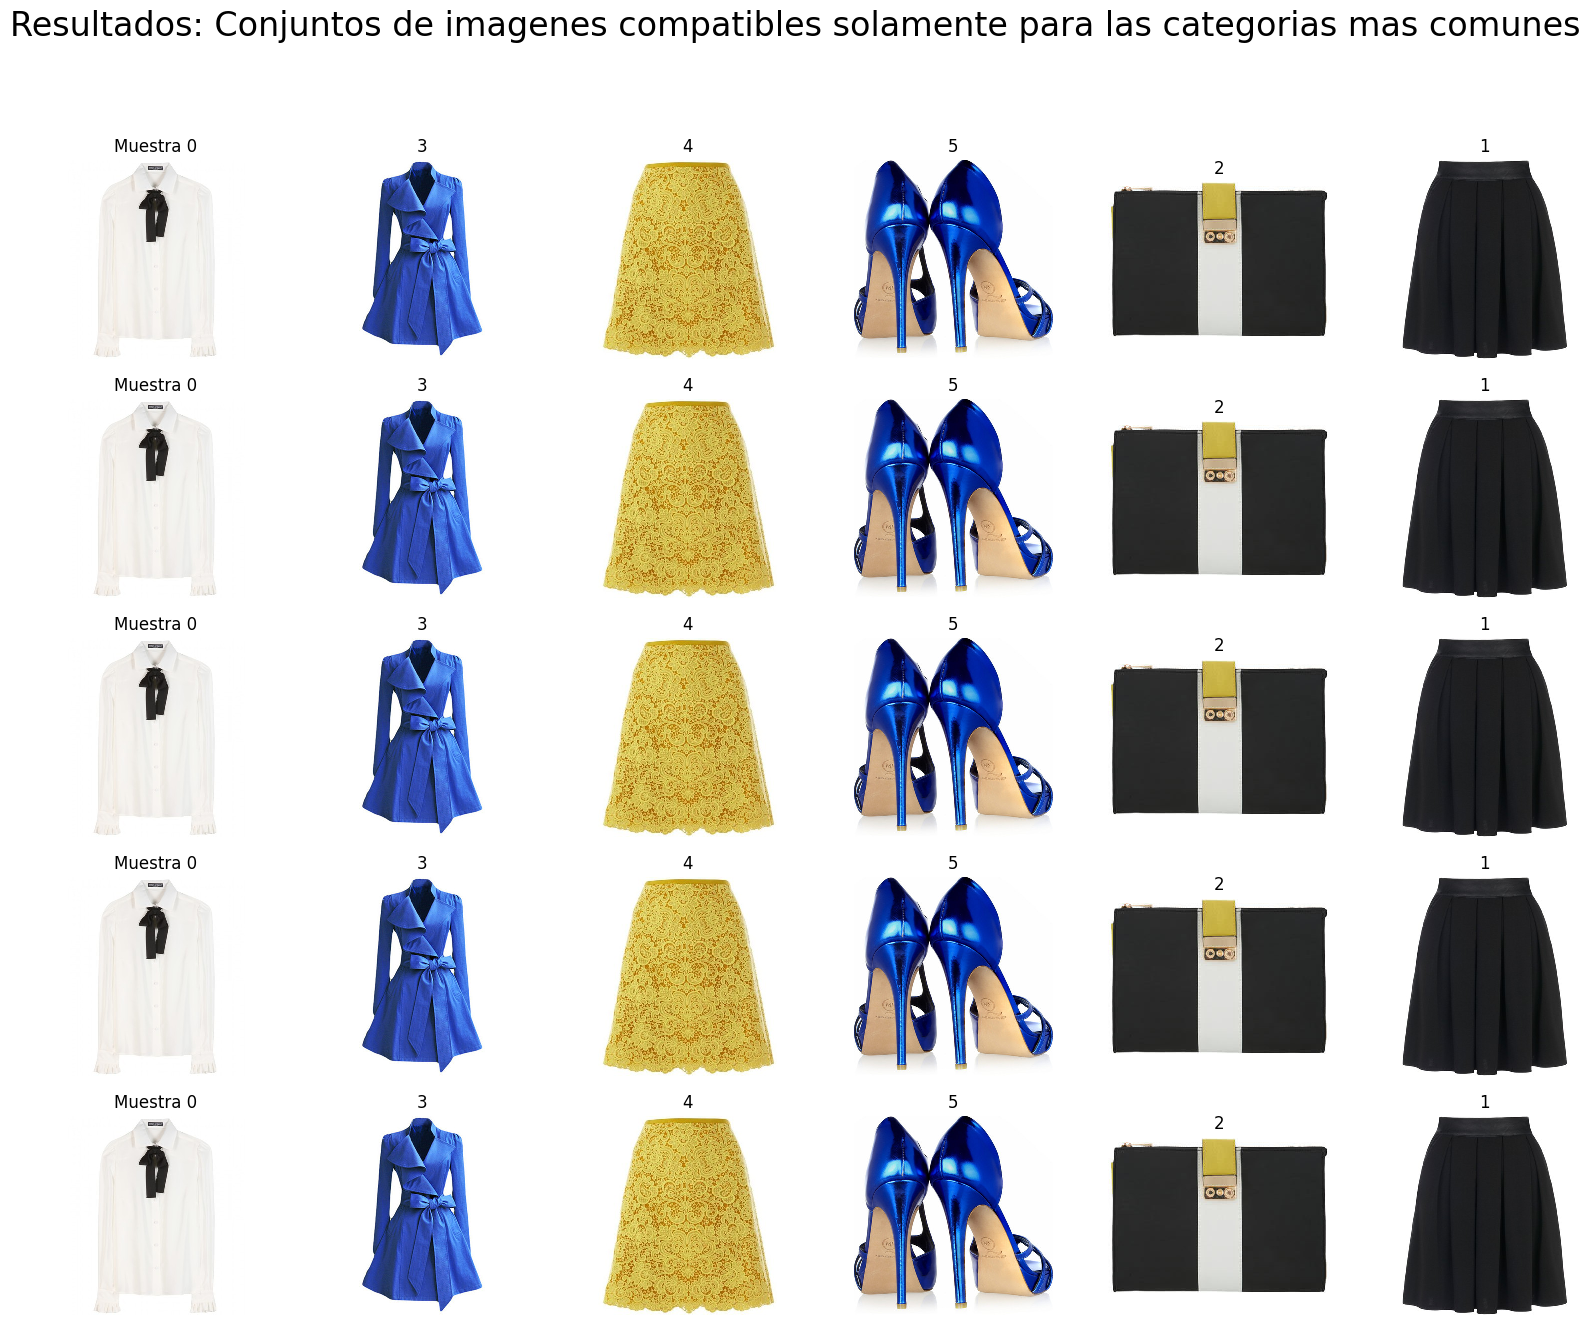

In [11]:
# si ocurre error DefaultCPUAllocator: can't allocate memory, reducir el num_workers y batch_size

from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import numpy as np

# important libraries for ML models
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
from sklearn.neighbors import NearestNeighbors
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import time


def default_image_loader(path):
    return Image.open(path).convert('RGB')


def main():
    torch.set_printoptions(linewidth=200)
    
    
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

    # info of training, validation and testing images and meta-data and load
    polyvore_train = os.path.join(polyvore_info, 'train_no_dup.json')
    polyvore_val = os.path.join(polyvore_info, 'valid_no_dup.json')
    polyvore_test = os.path.join(polyvore_info, 'test_no_dup.json')
    
    meta_data_train = json.load(open(polyvore_train, 'r'))
    meta_data_val = json.load(open(polyvore_val, 'r'))
    meta_data_test = json.load(open(polyvore_test, 'r'))
    
    # parámetros pre-definidos (revisar que se encuentren bien ajustados para la tarea )
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    batch_size = 200
    start_epoch = 1
    lr = 3e-3
    
    # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), \
                                 'fashion_proj', 'fashion_models', 'checkpoint_models')
    
    
    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")
    
    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
    
    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    resume = os.path.join(models_folder, 'BYOL_03_04.pth.tar')
    model_name = 'BYOL_03_04'
    #resume = False

    
    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])
    
    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 1
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )
    
    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2
    
    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        byol_learner = nn.DataParallel(byol_learner)
    byol_learner.to(device)
        
    #move data to device
    #polyvore_images.to(device)
    #polyvore_info.to(device)
    
    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                           ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    # se define el DataLoader de los datos de testeo
    test_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                           ]), return_image_path=True),
        batch_size=batch_size, shuffle=False, **kwargs)
    
    
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))
    
    
    # obtener la lista de embeddings de las imagenes
    embeddings_list = []
    images_list = []
    # for test/val data we get images only from the data loader
    
    print('antes de computar los embeddings')
    for batch_idx, images_info in enumerate(test_loader):
        images, categories, images_path = images_info
        
        with torch.no_grad():
            projections, embeddings = byol_learner(images, return_embedding = 'online')
        
        keep_cat = list(categories < 100)
        final_images_path = [x for x, y in zip(images_path, keep_cat) if y]
        final_embeddings = torch.stack([x for x, y in zip(embeddings, keep_cat) if y],  dim = 0)
        
        embeddings_list.append(final_embeddings)
        images_list.append(final_images_path)
    
    print('despues de embeddings')
    embeddings_list = torch.cat(embeddings_list)
    images_list = list(itertools.chain.from_iterable(images_list))
    
    # select random examples
    len_test = len(embeddings_list)
    
    print('largo de los embeddings: ', len_test)
    n_ejemplos = 5
    ejemplos = random.sample(range(0,len_test), n_ejemplos)
    
    print(ejemplos)

    # modelo de NearestNeighbours
    embeddings_list = embeddings_list.cpu()
    n_nbrs = 6
    nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(embeddings_list)
    print(embeddings_list)
    
    near_nei = nbrs.kneighbors(embeddings_list[ejemplos, :], return_distance=False)
    
    print(near_nei)
    print('entra aqui')
    # crear figura y subplots
    fig, ax = plt.subplots(n_ejemplos, n_nbrs, figsize=(20,15))
    for j in range(n_ejemplos):
        for i in range(n_nbrs):
            image_id = near_nei[j, i]
            example_img = default_image_loader(images_list[image_id])
            ax[j,i].imshow(example_img, interpolation='nearest')
            titulo = str(image_id)
            
            if i == 0: titulo = 'Muestra ' + titulo
            ax[j, i].set_title(titulo)
            ax[j, i].axis('off')

    
    # titulo de la figura
    fig.suptitle('Resultados: Conjuntos de imagenes compatibles solamente para las categorias mas comunes', fontsize=24)
    
    # PLOT RESULTS AND SETS OF COMPATIBLE CLOTHES
    plot_results = os.path.join(os.path.dirname(os.getcwd()), 'plot_results')
    current_folder = 'image_sets'
    
    directory = os.path.join(plot_results, current_folder, model_name)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plot_name = os.path.join(directory, '{}.png'.format(int(time.time())))
    plt.savefig(plot_name)
    
if __name__ == '__main__':
    main()   

In [12]:
X = np.array([[28273, 20866, 29961],[12343, 45634, 29961], [0, 0, 0], [130, 1600, 781], [1500, 1700, 30]])
knn = NearestNeighbors(n_neighbors=4)
knn.fit(X)

knn.kneighbors(X[0].reshape(1,-1), return_distance=False)

array([[0, 1, 4, 3]])

[[0 1]
 [1 0]
 [2 1]
 [3 4]
 [4 3]
 [5 4]]


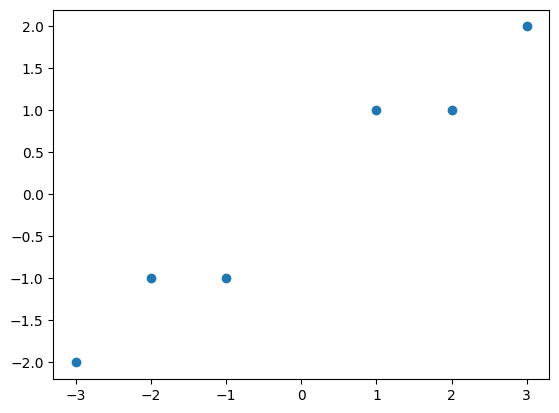

In [15]:
# mostrar los datos en X, Y
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
brs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

print(indices)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = X[:,0]
y = X[:,1]

ax.scatter(x, y)
plt.show()

## 4. Visualización de imágenes y *augmentaciones*

A continuación, como paso intermedio, se visualizan las imágenes y las augmentaciones para alimentar al modelo. Esto se importante puesto que la eficiencia depende del modelo depende directamente de las augmentaciones que se eligan.

In [ ]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

# librerías importantes e importar BYOL
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
from sklearn.neighbors import NearestNeighbors
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import time
    
def main():


     # path to important folders
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')
    category_info = os.path.join(polyvore_info, 'category_id.txt')
    
    d = {}
    with open(category_info) as f:
        for line in f:
            (key, val) = line.split(' ', 1)
            d[int(key)] = val
            
    category_data = open(category_info, 'r')
    
     # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'fashion_models', 'checkpoint_models')

    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")

    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    val_arg = False
    test_arg = True
    resume = os.path.join(models_folder, 'model_best.pth.tar')

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])

    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 1
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )



    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2

    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        byol_learner = nn.DistributedDataParallel(byol_learner)
    byol_learner.to(device)



    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)

            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))


    # augmentación to apply
    augmentation = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(),
                           normalize])



    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights='DEFAULT')

    # dataloader for the validation data
    val_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info, transform=transforms.ToTensor()),
        batch_size=1, shuffle=True)
    
    
    ## COMENTAR DESPUES
    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ]), return_image_path=True),
        batch_size=1, shuffle=True, **kwargs)
    
    # get random image from the batch
    for batch_idx, image_info in enumerate(train_loader):
        img1, img1category, anchor_im, img2, img2category, pos_im, img3, img3category, neg_im = image_info
    ## HASTA ACA

    # get random image from the batch
    sample_tensor = None
    sample_category = None
    for batch_idx, image_info in enumerate(val_loader):
        sample_tensor, sample_category = image_info
        break

    # preprocess the tensor and augment it
    sample_tensor = sample_tensor.squeeze()
    augmentated_tensor = augmentation(sample_tensor)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    sample_image = np.transpose(sample_tensor, (1, 2, 0))
    augmentated_image = np.transpose(augmentated_tensor, (1, 2, 0))
    
    image_cat = d[int(sample_category[0])]
    
    
    # crear figura y subplots
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample_image, interpolation='nearest')
    ax[0].set_title('Imagen original', fontweight ="bold")
    ax[0].axis('off')


    ax[1].imshow(augmentated_image, interpolation='nearest')
    ax[1].set_title('Imagen Augmentada', fontweight ="bold")
    ax[1].axis('off')

    # titulo de la figura
    fig.suptitle('Muestra de augmentación de imágen. Categoria {}'.format(image_cat), fontsize=16)


if __name__ == '__main__':
    main() 